# Imports

In [1]:
import numpy as np
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

#### <font color='blue'> Put your imports here </font> 

In [2]:
## put yours imports here

# A. Load and process data

In [3]:
df = pd.read_csv('stack_traces.csv', index_col = [0])
df.head()

,typeStackTrace,stackTrace
0,java.lang.Throwable,class java.lang.Throwable : __trad__AABHQ29udH...
1,java.lang.Throwable,class java.lang.Throwable : __trad__AABUQ29udH...
2,java.lang.Throwable,class java.lang.Throwable : __trad__AABHQ29udH...
3,org.eclipse.swt.SWTException,class org.eclipse.swt.SWTException : Widget is...
4,java.lang.Throwable,class java.lang.Throwable : __trad__AABnQ29udH...


### <font color='red'> A.1. TO DO: Take only the most 500 frequent stack traces and load it into a new dataframe "df_distinct_stack_traces" </font>

### <font color='green'> A.1. Solution: (Provided) </font> 

In [4]:
n_unique_stack_traces = 500
df_distinct_stack_traces = pd.DataFrame()
df_distinct_stack_traces['stackTrace'] = df['stackTrace'].value_counts().index[:n_unique_stack_traces]
df_distinct_stack_traces.head()

,stackTrace
0,class java.lang.Exception : null\r\nat com.myC...
1,class java.lang.Exception : null\nat com.myCom...
2,class java.lang.Exception : null\nat com.myCom...
3,class java.lang.Exception : null\r\nat com.myC...
4,class java.lang.Exception : null\r\nat com.myC...


### <font color='red'> A.2.  TO DO: Parse all the stack traces into a list of frames and return the result as a new column "listFrames" in "df_distinct_stack_traces" </font>
#### **Hint:** to accelerate the process, use the function [pandas.DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html)

### <font color='green'> A.2. Solution: (Provided) </font> 

#### A.2.1. Parse the stack traces

In [5]:
'UTIL FUNCTIONS TO PARSE STACK TRACES'

# given a stack trace in a string format: return a dictionnary of information about the stack trace"
def extract_stack_traces_from_text(text):
    text = text.replace('\tat','at')
    text = text.replace(' at','\nat') 
    list_lines = text.split('\n')
    d_stack = dict()
    d_stack = extract_info_stack_traces(list_lines, d_stack) #extract all info about the stack trace
    return d_stack

def extract_info_stack_traces(list_lines, d_stack) :
    level = 0
    continu = False
    d_stack['is_truncated'] = False
    d_stack['level'] = level

    for i, line in enumerate(list_lines) :
        line = line.strip(' ')
          
        if re.search(r"Caused\s", line) :
            level += 1
            continu = True
            if re.search(r"[^\s]+\.+[\w\$\d\.]+(Exception)", line) :
                list_lines.insert(i+1, re.search(r"[^\s]+\.+[\w\$\d\.]+(Exception)", line).group())
            
            break 

        elif re.search(r"^at\s", line) :
            
            if re.search("\.\.\.\s[\d]+\smore", line):
                line = re.sub("\.\.\.\s[\d]+\smore",'', line)
                d_stack['is_truncated'] = True

            is_init = re.search("[^\s]*\.[\w\$\d]+\.\<init\>\([^)]*\)$", line)
            is_file = re.search("[^\s]*\.[\w\$\d]+\([^)]*\)", line)
            if is_init :
                l1 = re.sub(r'.\<init\>', '.ctor', is_init.group())
                if 'list_frames' in d_stack :
                    d_stack['list_frames'] = d_stack['list_frames'] + [re.sub(r'\([^)]*\)', '', l1)]

                else :
                    d_stack['list_frames'] = [re.sub(r'\([^)]*\)', '', l1)]

            elif is_file :
                if 'list_frames' in d_stack :
                    d_stack['list_frames'] = d_stack['list_frames'] + [re.sub(r'\([^)]*\)', '', is_file.group())]

                else :
                    d_stack['list_frames'] = [re.sub(r'\([^)]*\)', '', is_file.group())]

            else :
                d_stack['is_truncated'] = True
        
        elif re.search(r"[^\s]+\.+[\w\$\d\.]+(Exception)", line) :
            d_stack['type_exception'] = re.search(r"[^\s]+\.+[\w\$\d\.]+(Exception)", line).group()
    
    if continu :
        d_stack['caused_by'] = {}
        extract_info_stack_traces(list_lines[i+1:], d_stack['caused_by'])
        d_stack['level'] = d_stack['caused_by']['level'] + 1
    
    return d_stack

#extract all the frames (handle the case of Caused by) : 
def extract_all_list_frames_from_dict(d) :
    if d['level'] == 0 :
        return d['list_frames']
    else :
        if 'list_frames' in d['caused_by'] :
            return extract_all_list_frames_from_dict(d['caused_by']) + d['list_frames'] 
        else :
            return d['list_frames']

### Example 1

In [6]:
stack_trace = df['stackTrace'][0]
dict_info_stack_trace = extract_stack_traces_from_text(stack_trace)
dict_info_stack_trace

{'is_truncated': True,
 'level': 0,
 'list_frames': ['com.myCompany.gpao.client.modules.atelier.poste.tools.dialogs.XMessageDialog.ctor',
  'com.myCompany.gpao.client.modules.atelier.poste.tools.dialogs.XMessageDialog.ctor',
  'com.myCompany.gpao.client.modules.atelier.poste.tools.dialogs.CtrlRecetteDialog.ctor',
  'com.myCompany.gpao.client.modules.atelier.poste.acq.InteractiveAcqQte.check',
  'com.myCompany.gpao.client.modules.atelier.poste.acq.UStockAcqStd.acquireQte',
  'com.myCompany.gpao.client.modules.atelier.poste.acces.ProdValidator_OF.corregraphy',
  'com.myCompany.gpao.client.modules.atelier.poste.recette.wrappers.select.LotFromSelectionAdapter.selectLigne',
  'com.myCompany.gpao.client.modules.atelier.poste.recette.wrappers.select.LotFromSelectionAdapter.selectLigne',
  'com.myCompany.gpao.client.modules.atelier.poste.recette.wrappers.select.LotFromSelectionAdapter.selectLigne',
  'com.myCompany.gpao.client.modules.atelier.poste.recette.wrappers.select.TableWrapper.valid',


In [7]:
extract_all_list_frames_from_dict(dict_info_stack_trace)

['com.myCompany.gpao.client.modules.atelier.poste.tools.dialogs.XMessageDialog.ctor',
 'com.myCompany.gpao.client.modules.atelier.poste.tools.dialogs.XMessageDialog.ctor',
 'com.myCompany.gpao.client.modules.atelier.poste.tools.dialogs.CtrlRecetteDialog.ctor',
 'com.myCompany.gpao.client.modules.atelier.poste.acq.InteractiveAcqQte.check',
 'com.myCompany.gpao.client.modules.atelier.poste.acq.UStockAcqStd.acquireQte',
 'com.myCompany.gpao.client.modules.atelier.poste.acces.ProdValidator_OF.corregraphy',
 'com.myCompany.gpao.client.modules.atelier.poste.recette.wrappers.select.LotFromSelectionAdapter.selectLigne',
 'com.myCompany.gpao.client.modules.atelier.poste.recette.wrappers.select.LotFromSelectionAdapter.selectLigne',
 'com.myCompany.gpao.client.modules.atelier.poste.recette.wrappers.select.LotFromSelectionAdapter.selectLigne',
 'com.myCompany.gpao.client.modules.atelier.poste.recette.wrappers.select.TableWrapper.valid',
 'com.myCompany.gpao.client.modules.atelier.poste.tools.cab.C

### Example 2

In [8]:
stack_trace = df['stackTrace'][57]
dict_info_stack_trace = extract_stack_traces_from_text(stack_trace)
dict_info_stack_trace

{'is_truncated': False,
 'level': 2,
 'type_exception': 'com.myCompany.core.exceptions.InfologicRuntimeException',
 'list_frames': ['com.myCompany.infoc.client.forms.results.ResultsPart.export',
  'com.myCompany.infoc.client.forms.results.ResultsPart.performExcelExport',
  'com.myCompany.infoc.client.forms.results.ResultsPart$2.run',
  'org.eclipse.jface.action.Action.runWithEvent',
  'org.eclipse.jface.action.ActionContributionItem.handleWidgetSelection',
  'org.eclipse.jface.action.ActionContributionItem.access$2',
  'org.eclipse.jface.action.ActionContributionItem$4.handleEvent',
  'org.eclipse.swt.widgets.EventTable.sendEvent',
  'org.eclipse.swt.widgets.Widget.sendEvent',
  'org.eclipse.swt.widgets.Display.runDeferredEvents',
  'org.eclipse.swt.widgets.Display.readAndDispatch',
  'org.eclipse.jface.window.Window.runEventLoop',
  'org.eclipse.jface.window.Window.open',
  'com.myCompany.core.client.Application.run',
  'com.myCompany.superviseur.client.SuperviseurApp.main'],
 'caused

In [9]:
extract_all_list_frames_from_dict(dict_info_stack_trace)

['com.myCompany.infoc.engine.export.ExcelResultExporter.export',
 'com.myCompany.infoc.client.forms.results.ResultsPart$ExportRunner.run',
 'org.eclipse.jface.operation.ModalContext$ModalContextThread.run',
 'com.myCompany.infoc.client.forms.results.ResultsPart.export',
 'com.myCompany.infoc.client.forms.results.ResultsPart.performExcelExport',
 'com.myCompany.infoc.client.forms.results.ResultsPart$2.run',
 'org.eclipse.jface.action.Action.runWithEvent',
 'org.eclipse.jface.action.ActionContributionItem.handleWidgetSelection',
 'org.eclipse.jface.action.ActionContributionItem.access$2',
 'org.eclipse.jface.action.ActionContributionItem$4.handleEvent',
 'org.eclipse.swt.widgets.EventTable.sendEvent',
 'org.eclipse.swt.widgets.Widget.sendEvent',
 'org.eclipse.swt.widgets.Display.runDeferredEvents',
 'org.eclipse.swt.widgets.Display.readAndDispatch',
 'org.eclipse.jface.window.Window.runEventLoop',
 'org.eclipse.jface.window.Window.open',
 'com.myCompany.core.client.Application.run',
 'co

#### A.2.2. Use the lambda function in the pandas apply to return the list of stack traces in a serie

In [10]:
df_distinct_stack_traces['listStackTrace'] = df_distinct_stack_traces['stackTrace'].apply(lambda x : extract_all_list_frames_from_dict(extract_stack_traces_from_text(x)))
df_distinct_stack_traces.head()

,stackTrace,listStackTrace
0,class java.lang.Exception : null\r\nat com.myC...,[com.myCompany.core.client.Application.createE...
1,class java.lang.Exception : null\nat com.myCom...,[com.myCompany.core.client.Application.createE...
2,class java.lang.Exception : null\nat com.myCom...,[com.myCompany.core.client.Application.createE...
3,class java.lang.Exception : null\r\nat com.myC...,[com.myCompany.core.client.Application.createE...
4,class java.lang.Exception : null\r\nat com.myC...,[com.myCompany.core.client.Application.createE...


# B. Compute all similarities between all stack trace pairs w.r.t. all similarity metrics

### <font color='red'> TO DO: For each similarity measure, implement a function that caluclates the similarity value between two stack traces." </font>
### <font color='red'> TO DO: Compute the similarities between all possible stack trace pairs while paralleling the computational process and using the minimum of storage (only the index) </font>
### <font color='red'> TO DO: Provide statistics about the similarity values: </font>
    - Distribution graph
    - Min value
    - Max value
    - Mean value
    - Median
    - Standard deviation
    - Variance
    |--------------------|-----------|-----------|------------|--------|------|----------|
    | Similarity measure | Min value | Max value | Mean value | Median | STD  | Variance |
    |--------------------|-----------|-----------|------------|--------|------|----------|
    |       Jaccard      |    0.0    |    1.0    |    0.17    |  0.13  | 0.19 |   0.04   |
    |--------------------|-----------|-----------|------------|--------|------|----------|
    |     Cosine BOW     |    0.0    |    1.0    |    0.25    |  0.22  | 0.25 |   0.06   |
    |--------------------|-----------|-----------|------------|--------|------|----------|
    |    Cosine TF-IDF   |    0.0    |    1.0    |    0.1     |  0.05  | 0.17 |   0.03   |
    |--------------------|-----------|-----------|------------|--------|------|----------|
    |   Cosine Bi-gram   |    0.0    |    1.0    |    0.22    |  0.17  | 0.24 |   0.06   |
    |--------------------|-----------|-----------|------------|--------|------|----------|
    |     Levenshtein    |    0.0    |    1.0    |    0.19    |  0.13  | 0.22 |   0.05   |
    |--------------------|-----------|-----------|------------|--------|------|----------|
    |         PDM        |    0.0    |    1.0    |    0.17    |  0.1   | 0.22 |   0.05   |
    |--------------------|-----------|-----------|------------|--------|------|----------|
    |      TraceSIM      |    0.0    |    1.0    |    0.18    |  0.12  | 0.21 |   0.04   |
    |--------------------|-----------|-----------|------------|--------|------|----------|

#### **Hint1:** Use the function [pandas.DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) twice for the column "listStackTrace" as illustrated in the diagram below
#### **Hint2:** create a new dataframe "df_measures" where its columns are (index_stack_trace_1, index_stack_trace_2, jaccard_values, cosine_bow_values, cosine_tfidf_values, ...)

### <font color='green'> **Solution**: (To complete ...) </font> 
**The solution is <font color='green'>provided</font> exclusively for the jaccard coefficient**

In [11]:
'UTIL FUNCTIONS TO HELP'
def get_index_sim(n_stacks, index_1, index_2) :
    return int(((2*n_stacks - (index_1+1)) * index_1) / 2 + (index_2 - index_1) -1)

def get_indexes_sim(n_stacks, index_similarity) :
    
    if index_similarity < n_stacks - 1 :
        return (0, index_similarity + 1)   
    
    else :
        lower_bound = int(n_stacks - 1.5 - math.sqrt((n_stacks - 1.5)**2 - 2*(index_similarity - n_stacks + 1)))
        upper_bound = int(n_stacks - 0.5 - math.sqrt((n_stacks - 0.5)**2 - 2*index_similarity)) + 1
        
        tmp = lower_bound
        continu = True
        while continu :
            if ((2*n_stacks - (tmp+1)) * tmp) / 2 <= index_similarity :
                a = tmp
                tmp += 1
            
            else : 
                continu = False
            
        return (a, int(index_similarity - (((2*n_stacks - (a+1)) * a) / 2) + a + 1))
    
def rowIndex(row):
    return row.name

In [12]:
#create new dataframe to store the similarity values w.r.t. the similarity measure
df_measures = pd.DataFrame(index = np.arange(int(n_unique_stack_traces * (n_unique_stack_traces-1) /2)))
df_measures['index_stack_trace_1'] = df_measures.index.to_series().apply(lambda x : get_indexes_sim(n_unique_stack_traces, x)[0])
df_measures['index_stack_trace_2'] = df_measures.index.to_series().apply(lambda x : get_indexes_sim(n_unique_stack_traces, x)[1])
df_measures

,index_stack_trace_1,index_stack_trace_2
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
124745,496,498
124746,496,499
124747,497,498
124748,497,499


## B.1. Jaccard Coefficient [[doc](https://en.wikipedia.org/wiki/Jaccard_index)]

In [13]:
def jaccard (l1, l2) :
    s1 = set(l1)
    s2 = set(l2)
    similarity = float(len(s1.intersection(s2)) / len(s1.union(s2)))
    return similarity

def jaccard_df(s, s_copy, index) :
    return s_copy.apply(lambda x : jaccard(x, s)).tolist()[index+1:]

### Testing

In [14]:
"The output must be ~ 0.83 "
list_stack_1 = df_distinct_stack_traces['listStackTrace'][0]
list_stack_2 = df_distinct_stack_traces['listStackTrace'][1]
jaccard(list_stack_1, list_stack_2)

0.8333333333333334

In [15]:
%%time
# With paralleling the computational process
df_distinct_stack_traces['jaccard_similarities'] = df_distinct_stack_traces.apply(lambda x : jaccard_df(x['listStackTrace'], df_distinct_stack_traces['listStackTrace'], rowIndex(x)), axis = 1)
df_distinct_stack_traces['jaccard_similarities']

CPU times: user 1.27 s, sys: 16 ms, total: 1.29 s
Wall time: 1.29 s


0      [0.8333333333333334, 0.8333333333333334, 0.833...
1      [1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, ...
2      [1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, ...
3      [1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 0.833...
4      [1.0, 0.8333333333333334, 1.0, 1.0, 0.83333333...
                             ...                        
495               [0.0, 0.08333333333333333, 0.2, 0.875]
496                      [0.0, 0.10344827586206896, 0.0]
497           [0.14705882352941177, 0.08333333333333333]
498                                                [0.2]
499                                                   []
Name: jaccard_similarities, Length: 500, dtype: object

In [16]:
df_measures['jaccard_values'] = pd.Series([elt for l in df_distinct_stack_traces['jaccard_similarities'] for elt in l])
df_measures

,index_stack_trace_1,index_stack_trace_2,jaccard_values
0,0,1,0.833333
1,0,2,0.833333
2,0,3,0.833333
3,0,4,0.833333
4,0,5,0.833333
...,...,...,...
124745,496,498,0.103448
124746,496,499,0.000000
124747,497,498,0.147059
124748,497,499,0.083333


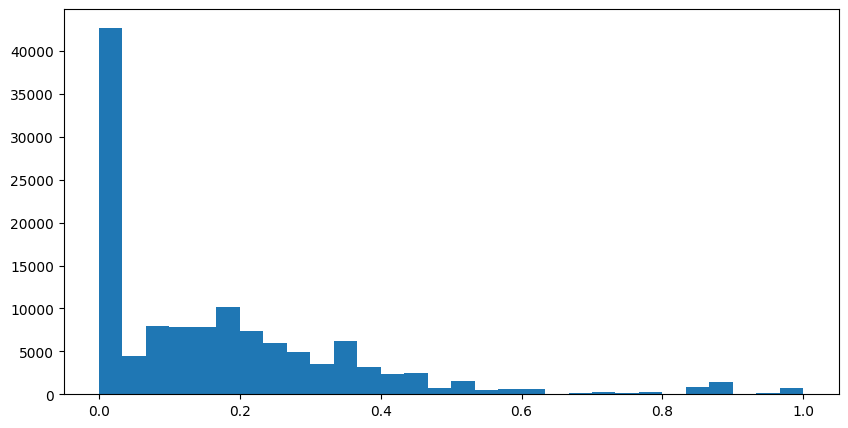

In [17]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['jaccard_values'], 30, alpha = 1, density = False)
plt.show()

#### <font color='blue'> Complete your own code here ...  </font> 

In [18]:
# With for loop method
list_jaccard_values = []
'Complete your code here ..............'
for i in range(len(df_distinct_stack_traces)):
    for j in range(i+1, len(df_distinct_stack_traces)):
        vect_1 = df_distinct_stack_traces['listStackTrace'][i]
        vect_2 = df_distinct_stack_traces['listStackTrace'][j]
        list_jaccard_values.append(jaccard(vect_1, vect_2))

In [19]:
'Assert the values are correct'
assert df_measures['jaccard_values'].equals(pd.Series(list_jaccard_values))

#### <font color='blue'> Complete your own code here ...  </font> 

In [20]:
import statistics

'Complete your code here ............................ and print statistics'

print('The min values is:', round(min(list_jaccard_values),2))
print('The max values is:', round(max(list_jaccard_values),2))
print('The mean values is:', round(statistics.mean(list_jaccard_values),2))
print('The median values is:', round(statistics.median(list_jaccard_values),2))
print('The std values is:', round(np.std(list_jaccard_values),2))
print('The variance values is:', round(np.var(list_jaccard_values),2)) 

The min values is: 0.0
The max values is: 1.0
The mean values is: 0.17
The median values is: 0.13
The std values is: 0.19
The variance values is: 0.04


## B.2. Cosine BOW [[doc](https://en.wikipedia.org/wiki/Cosine_similarity)]

#### **Hint1:** U need to form a matrix "matrix_of_frames" where lines are stack traces and columns (features) are all the distinct frames, hence, the matrix values indicate the frequency of a particular frame in a given stack trace

#### <font color='blue'> Complete your own code here ...  </font> 

In [21]:
'Complete your code here ...'
matrix_of_frames = []
all_distinct_frames = []

for i in range(n_unique_stack_traces):
    for j in range(len(df_distinct_stack_traces['listStackTrace'][i])):
        if df_distinct_stack_traces['listStackTrace'][i][j] not in all_distinct_frames:
            all_distinct_frames.append(df_distinct_stack_traces['listStackTrace'][i][j])

zeroed_counter = {frame: 0 for frame in all_distinct_frames}
# Each row will carry a copy of this 0-count dictionary

matrix_of_frames = [zeroed_counter.copy() for _ in df_distinct_stack_traces['listStackTrace']]

for stack_trace, stack_trace_count in zip(df_distinct_stack_traces['listStackTrace'], matrix_of_frames):
    # Iterating over each individual listStackTrace and its corresponding count dictionary
    for frame in stack_trace:
        stack_trace_count[frame] += 1

df_matrix_of_frames = pd.DataFrame(data = matrix_of_frames, columns = all_distinct_frames)
df_matrix_of_frames

,com.myCompany.core.client.Application.createErrorDialog,com.myCompany.core.client.Application.access$3,com.myCompany.core.client.Application$6.run,org.eclipse.swt.widgets.RunnableLock.run,org.eclipse.swt.widgets.Synchronizer.runAsyncMessages,org.eclipse.swt.widgets.Display.runAsyncMessages,org.eclipse.swt.widgets.Display.readAndDispatch,org.eclipse.jface.window.Window.runEventLoop,org.eclipse.jface.window.Window.open,com.myCompany.core.client.Application.run,...,com.myCompany.infoc.engine.charts.Charts.createData,com.myCompany.infoc.services.infocentre.tableaubord.HighchartsGenerator.buildChartOptions,com.myCompany.infoc.client.forms.results.html.HtmlComponent.setChart,com.myCompany.superviseur.client.drivers.lectcab.LectCab$$Lambda$160/10277112.keyTraversed,com.myCompany.superviseur.services.preparation.prepprep.impl.PrepPrepServiceImpl$$EnhancerByCGLIB$$39e02ed1.CGLIB$registerMouvementInTransaction$0$14,com.myCompany.superviseur.client.modules.postpreparation.otprep.tache.OTPrepTache$$Lambda$131/8916001.run,com.myCompany.superviseur.client.modules.postpreparation.otprep.tache.OTPrepTache$$Lambda$132/24367863.run,com.myCompany.core.client.modules.tables.LabelProvider.getColumnImage,com.myCompany.core.client.modules.tables.TableCellRenderer.toImage,com.myCompany.superviseur.client.modules.postpreparation.otprep.tache.OTPrepTache$$Lambda$133/26709830.run
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
497,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,1,1,0
498,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


#### <font color='blue'> Complete your own code here ...  </font> 

In [22]:
'Implement the functions'
from numpy.linalg import norm

def cosine_similarity(vect1, vect2):
	return np.dot(vect1,vect2)/(norm(vect1)*norm(vect2))

def cosine_similarity_df(s, s_copy, index) :
    return s_copy.apply(lambda x: cosine_similarity(x, s), axis=1).tolist()[index+1:]

In [23]:
"The output must be ~ 0.90 "
vect_stack_1 = df_matrix_of_frames.iloc[0]
vect_stack_2 = df_matrix_of_frames.iloc[1]
cosine_similarity(vect_stack_1, vect_stack_2)


0.9090909090909091

#### <font color='blue'> Complete your own code here ...  </font> 

In [24]:
'Complete your code here ..............'

# With parallelizing the computational process
df_distinct_stack_traces['cosine_bow_similarities'] = df_matrix_of_frames.apply(lambda x: cosine_similarity_df(x, df_matrix_of_frames, rowIndex(x)), axis=1)
df_distinct_stack_traces['cosine_bow_similarities']

0      [0.9090909090909091, 0.9090909090909091, 0.909...
1      [1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, ...
2      [1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, ...
3      [1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 0.909...
4      [1.0, 0.9090909090909091, 1.0, 1.0, 0.90909090...
                             ...                        
495    [0.0, 0.125, 0.27777777777777785, 0.9444444444...
496                       [0.0, 0.2773500981126146, 0.0]
497                          [0.2916666666666667, 0.125]
498                                [0.27777777777777785]
499                                                   []
Name: cosine_bow_similarities, Length: 500, dtype: object

In [25]:
df_measures['cosine_bow_values'] = pd.Series([elt for l in df_distinct_stack_traces['cosine_bow_similarities'] for elt in l])
df_measures

,index_stack_trace_1,index_stack_trace_2,jaccard_values,cosine_bow_values
0,0,1,0.833333,0.909091
1,0,2,0.833333,0.909091
2,0,3,0.833333,0.909091
3,0,4,0.833333,0.909091
4,0,5,0.833333,0.909091
...,...,...,...,...
124745,496,498,0.103448,0.277350
124746,496,499,0.000000,0.000000
124747,497,498,0.147059,0.291667
124748,497,499,0.083333,0.125000


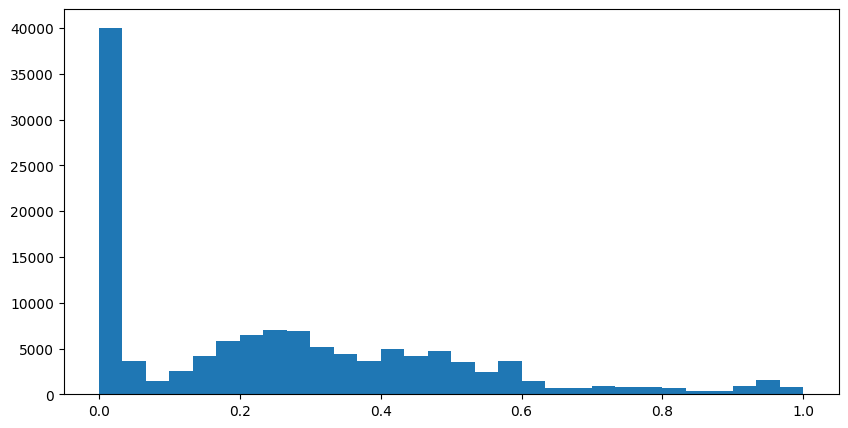

In [26]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['cosine_bow_values'] , 30, alpha = 1, density = False)
plt.show()

#### <font color='blue'> Complete your own code here ...  </font> 

In [27]:
# With for loop method
list_cosine_bow_values = []
'Complete your code here ..............'
for i in range(len(df_distinct_stack_traces)):
    for j in range(i+1, len(df_distinct_stack_traces)):
        vect_1 = df_matrix_of_frames.iloc[i]
        vect_2 = df_matrix_of_frames.iloc[j]
        list_cosine_bow_values.append(cosine_similarity(vect_1, vect_2))

In [28]:
'Assert the values are correct'
assert df_measures['cosine_bow_values'].equals(pd.Series(list_cosine_bow_values))

#### <font color='blue'> Complete your own code here ...  </font> 

In [29]:
import statistics

'Complete your code here ............................ and print statistics'

print('The min values is:', round(min(list_cosine_bow_values),2))
print('The max values is:', round(max(list_cosine_bow_values),2))
print('The mean values is:', round(statistics.mean(list_cosine_bow_values),2))
print('The median values is:', round(statistics.median(list_cosine_bow_values),2))
print('The std values is:', round(np.std(list_cosine_bow_values),2))
print('The variance values is:', round(np.var(list_cosine_bow_values),2)) 

The min values is: 0.0
The max values is: 1.0
The mean values is: 0.25
The median values is: 0.22
The std values is: 0.25
The variance values is: 0.06


## B.3. Cosine TF-IDF [[doc](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)]


#### **Hint1:** U need to form a matrix "matrix_of_frames_tfidf" where lines are stack traces and columns (features) are all the distinct frames, BUT, the matrix values indicate the TF-IDF (not frequency) of a particular frame in a given stack trace

#### <font color='blue'> Complete your own code here ...  </font> 

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the tokenized vocabulary manually
def dummy(doc):
    return doc
tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy,
    preprocessor=dummy,
    token_pattern=None) 
 
# List of the 500 stacktraces frames
list_all_stacktaces = []
for i in range(n_unique_stack_traces):
    list_all_stacktaces.append(df_distinct_stack_traces['listStackTrace'][i]) 

In [31]:
'Complete your code here ..............'
tfidf_values = tfidf.fit_transform(list_all_stacktaces)
matrix_of_frames_tfidf = tfidf_values.toarray()
df_matrix_of_frames_tfidf = pd.DataFrame(data = matrix_of_frames_tfidf, columns = tfidf.vocabulary_)
df_matrix_of_frames_tfidf


,com.myCompany.core.client.Application.createErrorDialog,com.myCompany.core.client.Application.access$3,com.myCompany.core.client.Application$6.run,org.eclipse.swt.widgets.RunnableLock.run,org.eclipse.swt.widgets.Synchronizer.runAsyncMessages,org.eclipse.swt.widgets.Display.runAsyncMessages,org.eclipse.swt.widgets.Display.readAndDispatch,org.eclipse.jface.window.Window.runEventLoop,org.eclipse.jface.window.Window.open,com.myCompany.core.client.Application.run,...,com.myCompany.infoc.engine.charts.Charts.createData,com.myCompany.infoc.services.infocentre.tableaubord.HighchartsGenerator.buildChartOptions,com.myCompany.infoc.client.forms.results.html.HtmlComponent.setChart,com.myCompany.superviseur.client.drivers.lectcab.LectCab$$Lambda$160/10277112.keyTraversed,com.myCompany.superviseur.services.preparation.prepprep.impl.PrepPrepServiceImpl$$EnhancerByCGLIB$$39e02ed1.CGLIB$registerMouvementInTransaction$0$14,com.myCompany.superviseur.client.modules.postpreparation.otprep.tache.OTPrepTache$$Lambda$131/8916001.run,com.myCompany.superviseur.client.modules.postpreparation.otprep.tache.OTPrepTache$$Lambda$132/24367863.run,com.myCompany.core.client.modules.tables.LabelProvider.getColumnImage,com.myCompany.core.client.modules.tables.TableCellRenderer.toImage,com.myCompany.superviseur.client.modules.postpreparation.otprep.tache.OTPrepTache$$Lambda$133/26709830.run
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.424099,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.182298,0.0,0.0,0.0,0.0,0.0,0.199397,0.199397
497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [32]:
"The output must be ~ 0.87"
vect_stack_1 = df_matrix_of_frames_tfidf.iloc[0]
vect_stack_2 = df_matrix_of_frames_tfidf.iloc[1]
cosine_similarity(vect_stack_1, vect_stack_2)

0.8688203192015256

#### <font color='blue'> Complete your own code here ...  </font> 

In [33]:
'Complete your code here ..............'
# With paralleling the computational process
df_distinct_stack_traces['cosine_tfidf_similarities'] = df_matrix_of_frames_tfidf.apply(lambda x: cosine_similarity_df(x, df_matrix_of_frames_tfidf, rowIndex(x)), axis=1)
df_distinct_stack_traces['cosine_tfidf_similarities']

0      [0.8688203192015256, 0.8688203192015256, 0.868...
1      [1.0, 1.0, 1.0, 1.0, 0.8688203192015256, 1.0, ...
2      [1.0, 1.0, 1.0, 0.8688203192015256, 1.0, 1.0, ...
3      [1.0, 1.0, 0.8688203192015256, 1.0, 1.0, 0.868...
4      [1.0, 0.8688203192015256, 1.0, 1.0, 0.86882031...
                             ...                        
495    [0.0, 0.017133699314021276, 0.0615320670077773...
496                       [0.0, 0.3052568018879289, 0.0]
497          [0.06068615608481799, 0.017133699314021276]
498                                [0.06153206700777739]
499                                                   []
Name: cosine_tfidf_similarities, Length: 500, dtype: object

In [34]:
df_measures['cosine_tfidf_values'] = pd.Series([elt for l in df_distinct_stack_traces['cosine_tfidf_similarities'] for elt in l])
df_measures

,index_stack_trace_1,index_stack_trace_2,jaccard_values,cosine_bow_values,cosine_tfidf_values
0,0,1,0.833333,0.909091,0.868820
1,0,2,0.833333,0.909091,0.868820
2,0,3,0.833333,0.909091,0.868820
3,0,4,0.833333,0.909091,0.868820
4,0,5,0.833333,0.909091,0.868820
...,...,...,...,...,...
124745,496,498,0.103448,0.277350,0.305257
124746,496,499,0.000000,0.000000,0.000000
124747,497,498,0.147059,0.291667,0.060686
124748,497,499,0.083333,0.125000,0.017134


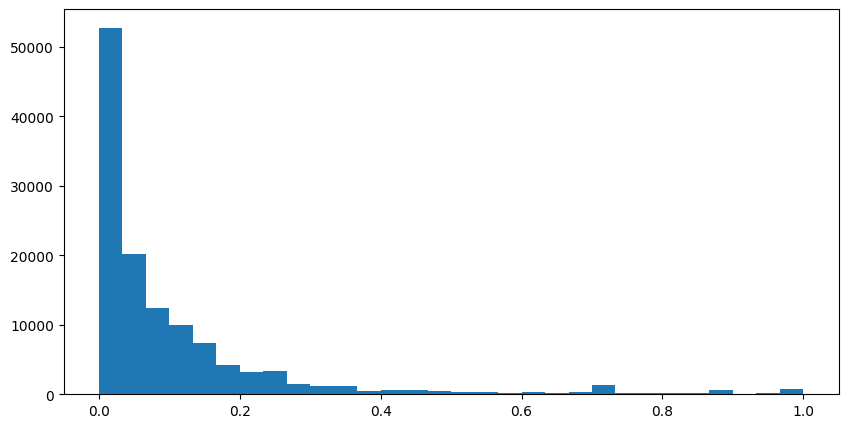

In [35]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['cosine_tfidf_values'], 30, alpha = 1, density = False)
plt.show()

#### <font color='blue'> Complete your own code here ...  </font> 

In [36]:
%%time
# With for loop method
list_cosine_tfidf_values = []
'Complete your code here ..............'

for i in range(len(df_distinct_stack_traces)):
    for j in range(i+1, len(df_distinct_stack_traces)):
        vect_1 = df_matrix_of_frames_tfidf.iloc[i]
        vect_2 = df_matrix_of_frames_tfidf.iloc[j]
        list_cosine_tfidf_values.append(cosine_similarity(vect_1, vect_2))

CPU times: user 19.1 s, sys: 15.8 ms, total: 19.1 s
Wall time: 19.1 s


In [37]:
'Assert the values are correct'
assert df_measures['cosine_tfidf_values'].equals(pd.Series(list_cosine_tfidf_values))

#### <font color='blue'> Complete your own code here ...  </font> 

In [38]:
import statistics

'Complete your code here ............................ and print statistics'

print('The min values is:', round(min(list_cosine_tfidf_values),2))
print('The max values is:', round(max(list_cosine_tfidf_values),2))
print('The mean values is:', round(statistics.mean(list_cosine_tfidf_values),2))
print('The median values is:', round(statistics.median(list_cosine_tfidf_values),2))
print('The std values is:', round(np.std(list_cosine_tfidf_values),2))
print('The variance values is:', round(np.var(list_cosine_tfidf_values),2)) 

The min values is: 0.0
The max values is: 1.0
The mean values is: 0.1
The median values is: 0.05
The std values is: 0.17
The variance values is: 0.03


## B.4. Cosine Bi-gram[[doc](https://en.wikipedia.org/wiki/N-gram)]


#### **Hint1:** U need to form a matrix "matrix_of_frames_bigram" where lines are stack traces and columns (features) are all the distinct bigram-frames and the matrix values indicate the frequency of a particular bigram-frame in a given stack trace

#### <font color='blue'> Complete your own code here ...  </font> 

In [39]:
'Complete your code here ..............'

from sklearn.feature_extraction.text import CountVectorizer

# List of the 500 stacktraces frames
list_all_stacktaces = []
for i in range(n_unique_stack_traces):
    list_all_stacktaces.append(df_distinct_stack_traces['listStackTrace'][i]) 

# Define the tokenized vocabulary manually
def dummy(doc):
    return doc

bigram_vectorizer = CountVectorizer(analyzer='word', tokenizer=dummy, preprocessor=dummy, ngram_range=(2, 2))
bigram_values = bigram_vectorizer.fit_transform(list_all_stacktaces)

matrix_of_frames_bigram = bigram_values.toarray()
df_matrix_of_frames_bigram = pd.DataFrame(data = matrix_of_frames_bigram, columns = bigram_vectorizer.vocabulary_)
df_matrix_of_frames_bigram

,com.myCompany.core.client.Application.createErrorDialog com.myCompany.core.client.Application.access$3,com.myCompany.core.client.Application.access$3 com.myCompany.core.client.Application$6.run,com.myCompany.core.client.Application$6.run org.eclipse.swt.widgets.RunnableLock.run,org.eclipse.swt.widgets.RunnableLock.run org.eclipse.swt.widgets.Synchronizer.runAsyncMessages,org.eclipse.swt.widgets.Synchronizer.runAsyncMessages org.eclipse.swt.widgets.Display.runAsyncMessages,org.eclipse.swt.widgets.Display.runAsyncMessages org.eclipse.swt.widgets.Display.readAndDispatch,org.eclipse.swt.widgets.Display.readAndDispatch org.eclipse.jface.window.Window.runEventLoop,org.eclipse.jface.window.Window.runEventLoop org.eclipse.jface.window.Window.open,org.eclipse.jface.window.Window.open com.myCompany.core.client.Application.run,com.myCompany.core.client.Application.run com.myCompany.achatsventes.client.VentesApp.main,...,com.myCompany.superviseur.services.preparation.prepprep.impl.PrepPrepServiceImpl.registerMouvementInTransaction com.myCompany.superviseur.services.preparation.prepprep.impl.PrepPrepServiceImpl$$EnhancerByCGLIB$$39e02ed1.CGLIB$registerMouvementInTransaction$0$14,com.myCompany.superviseur.services.preparation.prepprep.impl.PrepPrepServiceImpl$$EnhancerByCGLIB$$39e02ed1.CGLIB$registerMouvementInTransaction$0$14 com.myCompany.superviseur.services.preparation.prepprep.impl.PrepPrepServiceImpl$$EnhancerByCGLIB$$39e02ed1$$FastClassByCGLIB$$42ac4ecc.invoke,com.myCompany.superviseur.client.modules.postpreparation.otprep.tache.OTPrepTache.lambda$1 com.myCompany.superviseur.client.modules.postpreparation.otprep.tache.OTPrepTache$$Lambda$131/8916001.run,com.myCompany.superviseur.client.modules.postpreparation.otprep.tache.OTPrepTache$$Lambda$131/8916001.run com.myCompany.superviseur.client.util.uithread.ThreadUI$2.run,com.myCompany.superviseur.client.modules.postpreparation.otprep.tache.OTPrepTache.lambda$1 com.myCompany.superviseur.client.modules.postpreparation.otprep.tache.OTPrepTache$$Lambda$132/24367863.run,com.myCompany.superviseur.client.modules.postpreparation.otprep.tache.OTPrepTache$$Lambda$132/24367863.run com.myCompany.superviseur.client.util.uithread.ThreadUI$2.run,com.myCompany.core.client.modules.tables.LabelProvider.getColumnImage com.myCompany.core.client.modules.tables.TableCellRenderer.toImage,com.myCompany.core.client.modules.tables.TableCellRenderer.toImage com.myCompany.core.client.grid.DefaultGridCellRenderer.renderGridCell,com.myCompany.superviseur.client.modules.postpreparation.otprep.tache.OTPrepTache.lambda$1 com.myCompany.superviseur.client.modules.postpreparation.otprep.tache.OTPrepTache$$Lambda$133/26709830.run,com.myCompany.superviseur.client.modules.postpreparation.otprep.tache.OTPrepTache$$Lambda$133/26709830.run com.myCompany.superviseur.client.util.uithread.ThreadUI$2.run
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
496,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
"The output must be ~ 0.9 "
vect_stack_1 = df_matrix_of_frames_bigram.iloc[0]
vect_stack_2 = df_matrix_of_frames_bigram.iloc[1]
cosine_similarity(vect_stack_1, vect_stack_2)

0.8999999999999998

#### <font color='blue'> Complete your own code here ...  </font> 

In [41]:
%%time
# With paralleling the computational process
'Complete your code here ..............'
df_distinct_stack_traces['cosine_bigram_similarities'] = df_matrix_of_frames_bigram.apply(lambda x: cosine_similarity_df(x, df_matrix_of_frames_bigram, rowIndex(x)), axis=1)
df_distinct_stack_traces['cosine_bigram_similarities']

CPU times: user 15.6 s, sys: 7.42 ms, total: 15.6 s
Wall time: 15.6 s


0      [0.8999999999999998, 0.8999999999999998, 0.899...
1      [0.9999999999999998, 0.9999999999999998, 0.999...
2      [0.9999999999999998, 0.9999999999999998, 0.999...
3      [0.9999999999999998, 0.9999999999999998, 0.899...
4      [0.9999999999999998, 0.8999999999999998, 0.999...
                             ...                        
495    [0.0, 0.09938079899999065, 0.2666666666666666,...
496                       [0.0, 0.1777046633277277, 0.0]
497           [0.14907119849998599, 0.09938079899999065]
498                                 [0.2666666666666666]
499                                                   []
Name: cosine_bigram_similarities, Length: 500, dtype: object

In [42]:
df_measures['cosine_bigram_values'] = pd.Series([elt for l in df_distinct_stack_traces['cosine_bigram_similarities'] for elt in l])
df_measures

,index_stack_trace_1,index_stack_trace_2,jaccard_values,cosine_bow_values,cosine_tfidf_values,cosine_bigram_values
0,0,1,0.833333,0.909091,0.868820,0.900000
1,0,2,0.833333,0.909091,0.868820,0.900000
2,0,3,0.833333,0.909091,0.868820,0.900000
3,0,4,0.833333,0.909091,0.868820,0.900000
4,0,5,0.833333,0.909091,0.868820,0.900000
...,...,...,...,...,...,...
124745,496,498,0.103448,0.277350,0.305257,0.177705
124746,496,499,0.000000,0.000000,0.000000,0.000000
124747,497,498,0.147059,0.291667,0.060686,0.149071
124748,497,499,0.083333,0.125000,0.017134,0.099381


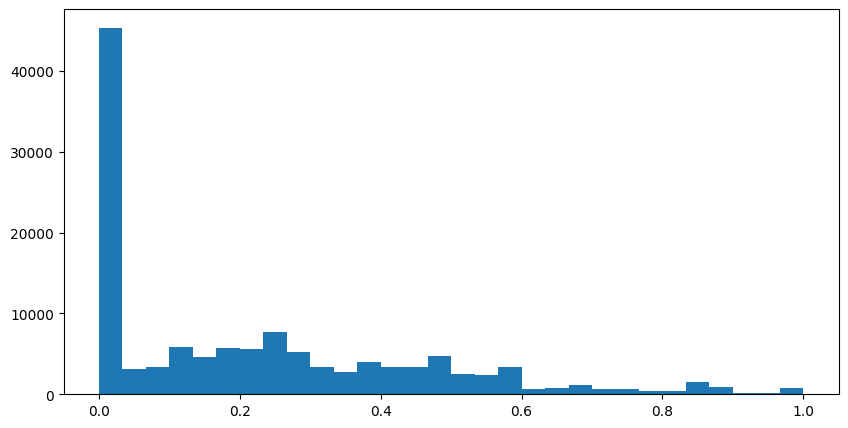

In [43]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['cosine_bigram_values'], 30, alpha = 1, density = False)
plt.show()

#### <font color='blue'> Complete your own code here ...  </font> 

In [44]:
# With for loop method
list_cosine_bigram_values = []
'Complete your code here ..............'

for i in range(len(df_distinct_stack_traces)):
    for j in range(i+1, len(df_distinct_stack_traces)):
        vect_1 = df_matrix_of_frames_bigram.iloc[i]
        vect_2 = df_matrix_of_frames_bigram.iloc[j]
        list_cosine_bigram_values.append(cosine_similarity(vect_1, vect_2))

In [45]:
'Assert the values are correct'
assert df_measures['cosine_bigram_values'].equals(pd.Series(list_cosine_bigram_values))

#### <font color='blue'> Complete your own code here ...  </font> 

In [46]:
'Complete your code here ............................ and print statistics'

print('The min values is:', round(min(list_cosine_bigram_values),2))
print('The max values is:', round(max(list_cosine_bigram_values),2))
print('The mean values is:', round(statistics.mean(list_cosine_bigram_values),2))
print('The median values is:', round(statistics.median(list_cosine_bigram_values),2))
print('The std values is:', round(np.std(list_cosine_bigram_values),2))
print('The variance values is:', round(np.var(list_cosine_bigram_values),2)) 

The min values is: 0.0
The max values is: 1.0
The mean values is: 0.22
The median values is: 0.17
The std values is: 0.24
The variance values is: 0.06


## B.5. Levenshtein similarity [[doc](https://en.wikipedia.org/wiki/Levenshtein_distance)]


#### <font color='blue'> Complete your own code here ...  </font> 

In [47]:
import rapidfuzz.distance.Levenshtein

'Implement the functions'
def levenshtein_similarity (list1, list2) :
    'Complete your code here ..............'
    similarity = rapidfuzz.distance.Levenshtein.normalized_similarity(list1, list2)
    return similarity

def levenshtein_df(s, s_copy, index) :
    'Complete your code here ..............'
    return s_copy.apply(lambda x: levenshtein_similarity(x, s)).tolist()[index + 1:]

In [48]:
"The output must be ~ 0.9"
list_stack_1 = df_distinct_stack_traces['listStackTrace'][0]
list_stack_2 = df_distinct_stack_traces['listStackTrace'][1]
levenshtein_similarity(list_stack_1, list_stack_2)

0.9090909090909091

#### <font color='blue'> Complete your own code here ...  </font> 

In [49]:
'Complete your code here ..............'
# With paralleling the computational process
df_distinct_stack_traces['levenshtein_similarities'] = df_distinct_stack_traces.apply(lambda x: levenshtein_df(x['listStackTrace'], df_distinct_stack_traces['listStackTrace'], rowIndex(x)), axis=1)
df_distinct_stack_traces['levenshtein_similarities']

0      [0.9090909090909091, 0.9090909090909091, 0.909...
1      [1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, ...
2      [1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, ...
3      [1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 0.909...
4      [1.0, 0.9090909090909091, 1.0, 1.0, 0.90909090...
                             ...                        
495           [0.0, 0.07692307692307687, 0.3125, 0.9375]
496                      [0.0, 0.19999999999999996, 0.0]
497           [0.11538461538461542, 0.07692307692307687]
498                                             [0.3125]
499                                                   []
Name: levenshtein_similarities, Length: 500, dtype: object

In [50]:
df_measures['levenshtein_values'] = pd.Series([elt for l in df_distinct_stack_traces['levenshtein_similarities']  for elt in l])
df_measures

,index_stack_trace_1,index_stack_trace_2,jaccard_values,cosine_bow_values,cosine_tfidf_values,cosine_bigram_values,levenshtein_values
0,0,1,0.833333,0.909091,0.868820,0.900000,0.909091
1,0,2,0.833333,0.909091,0.868820,0.900000,0.909091
2,0,3,0.833333,0.909091,0.868820,0.900000,0.909091
3,0,4,0.833333,0.909091,0.868820,0.900000,0.909091
4,0,5,0.833333,0.909091,0.868820,0.900000,0.909091
...,...,...,...,...,...,...,...
124745,496,498,0.103448,0.277350,0.305257,0.177705,0.200000
124746,496,499,0.000000,0.000000,0.000000,0.000000,0.000000
124747,497,498,0.147059,0.291667,0.060686,0.149071,0.115385
124748,497,499,0.083333,0.125000,0.017134,0.099381,0.076923


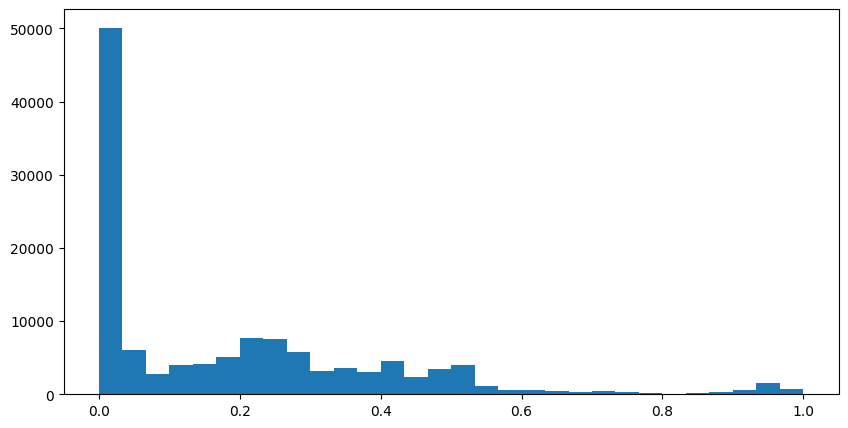

In [51]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['levenshtein_values'], 30, alpha = 1, density = False)
plt.show()

#### <font color='blue'> Complete your own code here ...  </font> 

In [52]:
# With for loop method
list_levenshtein_values = []
'Complete your code here ..............'

for i1 in range(len(df_distinct_stack_traces)):
    for i2 in range(i1 + 1, len(df_distinct_stack_traces)):
        list_stack_1 = df_distinct_stack_traces['listStackTrace'].iloc[i1]
        list_stack_2 = df_distinct_stack_traces['listStackTrace'].iloc[i2]
        list_levenshtein_values.append(levenshtein_similarity(list_stack_1, list_stack_2))

In [53]:
'Assert the values are correct'
assert df_measures['levenshtein_values'].equals(pd.Series(list_levenshtein_values))

#### <font color='blue'> Complete your own code here ...  </font> 

In [54]:
'Complete your code here ............................ and print statistics'

series_levenshtein_values = pd.Series(list_levenshtein_values)
attr = series_levenshtein_values.describe()

print('The min values is:', round(attr['min'], 2))
print('The max values is:', round(attr['max'], 2))
print('The mean values is:', round(attr['mean'], 2))
print('The median values is:', round(attr['50%'], 2))
print('The std values is:', round(attr['std'], 2))
print('The variance values is:', round(attr['std'] ** 2, 2)) 

The min values is: 0.0
The max values is: 1.0
The mean values is: 0.19
The median values is: 0.13
The std values is: 0.22
The variance values is: 0.05


## B.6. PDM - Rebucket [[Paper](https://www.researchgate.net/publication/254041628_ReBucket_A_method_for_clustering_duplicate_crash_reports_based_on_call_stack_similarity)]

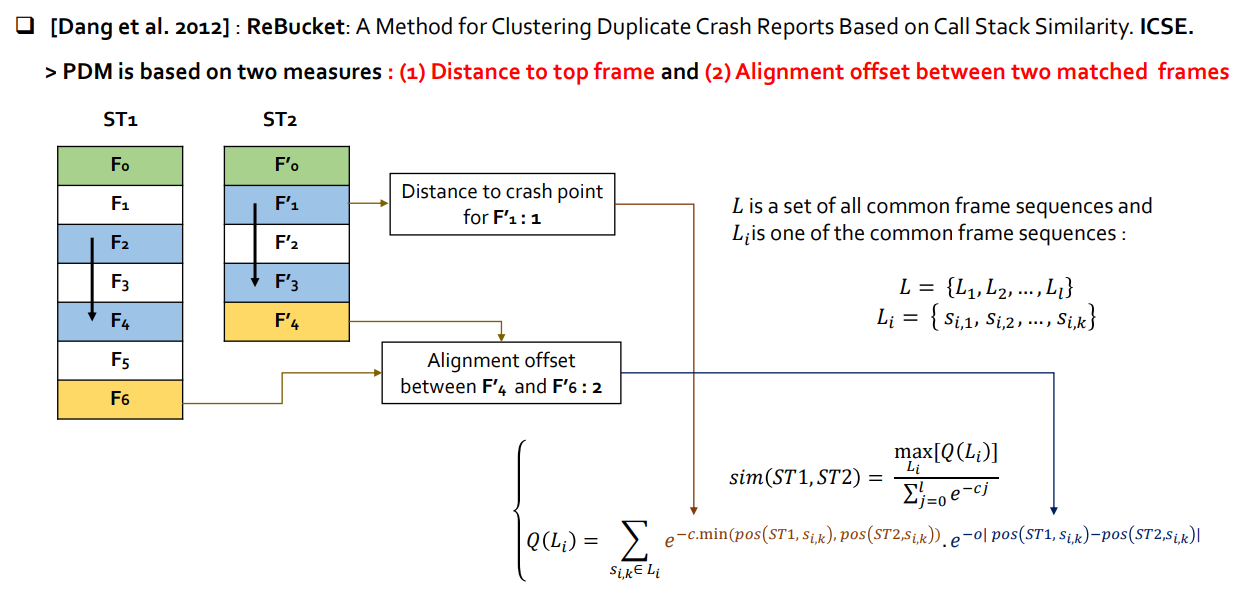

#### <font color='blue'> Complete your own code here ...  </font> 

In [55]:
'Implement the functions'
def pdm_similarity(stack1, stack2, c, o):

    stack_len1 = len(stack1)
    stack_len2 = len(stack2)
    if stack_len1 == stack_len2 :
        equal = True
        i = 0
        while equal and i < stack_len1   :
            if stack1[i] == stack2[i] :
                i += 1
            else :
                equal = False
        
    if (stack_len1 == stack_len2) and equal :
        return 1
    else :
        M = [[0. for i in range(stack_len2 + 1)] for j in range(stack_len1 + 1)]

        for i in range(1, stack_len1 + 1):
            for j in range(1, stack_len2 + 1):
                if stack1[i-1] == stack2[j-1]:
                    x = math.exp(-c*min(i-1,j-1)) * math.exp(-o*abs(i-j))
                else:
                    x = 0    
                M[i][j] = max(M[i-1][j-1]+x, M[i-1][j], M[i][j-1])
        sig = 0.
        for i in range(min(stack_len1, stack_len2) + 1):
            sig += math.exp(-c*i)
        sim = M[stack_len1][stack_len2]/sig
        return sim      
    
def pdm_df(s, s_copy, index, c, o) :
    return s_copy.apply(lambda x: pdm_similarity(x, s, c, o)).tolist()[index+1:]

In [56]:
"The output must be ~ 0.9"
list_stack_1 = df_distinct_stack_traces['listStackTrace'][0]
list_stack_2 = df_distinct_stack_traces['listStackTrace'][1]
pdm_similarity(list_stack_1, list_stack_2, c= 0.1, o = 0.1)

0.9045725859802668

#### <font color='blue'> Complete your own code here ...  </font> 

In [57]:
%%time
'Complete your code here ..............'
# With paralleling the computational process
df_distinct_stack_traces['pdm_similarities'] = df_distinct_stack_traces.apply(lambda x : pdm_df(x['listStackTrace'], df_distinct_stack_traces['listStackTrace'], rowIndex(x), c= 0.1, o = 0.1), axis=1)
df_distinct_stack_traces['pdm_similarities']

CPU times: user 50.1 s, sys: 26.8 ms, total: 50.1 s
Wall time: 50.2 s


0      [0.9045725859802668, 0.9045725859802668, 0.904...
1      [1.0, 1.0, 1.0, 1.0, 0.9045725859802668, 1.0, ...
2      [1.0, 1.0, 1.0, 0.9045725859802668, 1.0, 1.0, ...
3      [1.0, 1.0, 0.9045725859802668, 1.0, 1.0, 0.904...
4      [1.0, 0.9045725859802668, 1.0, 1.0, 0.90457258...
                             ...                        
495    [0.0, 0.035137135471484164, 0.1602495111231244...
496                      [0.0, 0.40336878512361257, 0.0]
497          [0.13479195137542116, 0.035137135471484164]
498                                [0.16024951112312444]
499                                                   []
Name: pdm_similarities, Length: 500, dtype: object

In [58]:
df_measures['pdm_values'] = pd.Series([elt for l in df_distinct_stack_traces['pdm_similarities']  for elt in l])
df_measures

,index_stack_trace_1,index_stack_trace_2,jaccard_values,cosine_bow_values,cosine_tfidf_values,cosine_bigram_values,levenshtein_values,pdm_values
0,0,1,0.833333,0.909091,0.868820,0.900000,0.909091,0.904573
1,0,2,0.833333,0.909091,0.868820,0.900000,0.909091,0.904573
2,0,3,0.833333,0.909091,0.868820,0.900000,0.909091,0.904573
3,0,4,0.833333,0.909091,0.868820,0.900000,0.909091,0.904573
4,0,5,0.833333,0.909091,0.868820,0.900000,0.909091,0.904573
...,...,...,...,...,...,...,...,...
124745,496,498,0.103448,0.277350,0.305257,0.177705,0.200000,0.403369
124746,496,499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
124747,497,498,0.147059,0.291667,0.060686,0.149071,0.115385,0.134792
124748,497,499,0.083333,0.125000,0.017134,0.099381,0.076923,0.035137


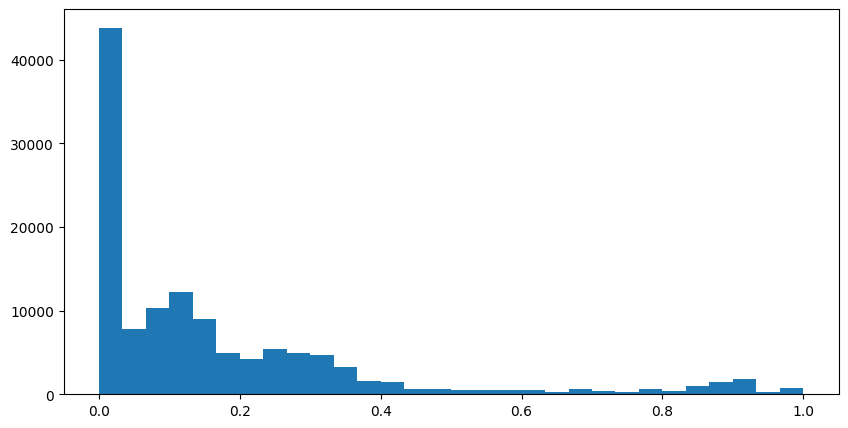

In [59]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['pdm_values'], 30, alpha = 1, density = False)
plt.show()

#### <font color='blue'> Complete your own code here ...  </font> 

In [60]:
%%time
# With for loop method
list_pdm_values = []
'Complete your code here ..............'
for i in range(len(df_distinct_stack_traces)):
    for j in range(i+1, len(df_distinct_stack_traces)):
        vect_1 = df_distinct_stack_traces['listStackTrace'][i]
        vect_2 = df_distinct_stack_traces['listStackTrace'][j]
        list_pdm_values.append(pdm_similarity(vect_1, vect_2,c= 0.1, o = 0.1))

CPU times: user 28.1 s, sys: 15.6 ms, total: 28.1 s
Wall time: 28.1 s


In [61]:
'Assert the values are correct'
assert df_measures['pdm_values'].equals(pd.Series(list_pdm_values))

#### <font color='blue'> Complete your own code here ...  </font> 

In [62]:
import statistics

'Complete your code here ............................ and print statistics'

print('The min values is:', round(min(list_pdm_values),2))
print('The max values is:', round(max(list_pdm_values),2))
print('The mean values is:', round(statistics.mean(list_pdm_values),2))
print('The median values is:', round(statistics.median(list_pdm_values),2))
print('The std values is:', round(np.std(list_pdm_values),2))
print('The variance values is:', round(np.var(list_pdm_values),2)) 

The min values is: 0.0
The max values is: 1
The mean values is: 0.17
The median values is: 0.1
The std values is: 0.22
The variance values is: 0.05


## B.7. TraceSIM [[Paper](https://arxiv.org/pdf/2009.12590.pdf)]

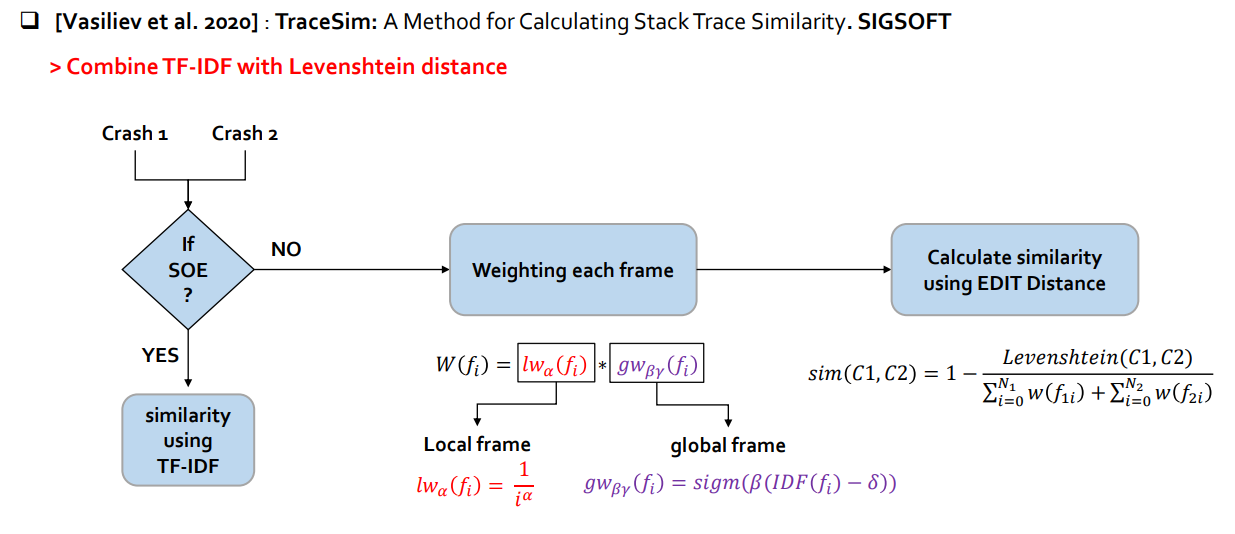

#### **Hint1:** U need to form a dictionnary where the keys are the distinct frames and the values are IDF
#### Use the formula : $idf(\text{frame}) = 1 + log(\frac{\text{number of stack traces}}{\text{number of stack traces that contains the frame}})$

#### <font color='blue'> Complete your own code here ...  </font> 

In [63]:
'Complete your code here .................'

def process_frame(frame) :
    frame = frame.lower()
    frame = frame.replace('$','')
    frame = frame.replace('/','')
    frame = frame.replace('<','')
    frame = frame.replace('>','')
    return frame


# Get all the distinct frames
distinct_frames_list = []
for f in sum(df_distinct_stack_traces['listStackTrace'], start=[]):
    if f not in distinct_frames_list:
        distinct_frames_list.append(process_frame(f)) # Append processed frame

N = len(df_distinct_stack_traces['listStackTrace'])

# Count is not necessary, only the presence indicator
presence_list = [False for _ in range(N)]
presence_indicator_dict = {frame: presence_list.copy() for frame in distinct_frames_list}

for i, stack_trace in enumerate(df_distinct_stack_traces['listStackTrace']):
    for frame in stack_trace:
        presence_indicator_dict[process_frame(frame)][i] |= True

# Once we have the presence indicator, we iterate again over each distinct frame to compute the IDF only

dict_idf_frames = dict() # Start with an empty dict

for frame in distinct_frames_list:
    appearances_in_traces = sum(presence_indicator_dict[frame])
    dict_idf_frames[frame] = 1 + math.log(N / appearances_in_traces)

dict_idf_frames['com.mycompany.achats.services.commande.impl.commandeserviceimpl.load']

7.214608098422191

#### <font color='blue'> Complete your own code here ...  </font> 

In [64]:
def traceSim_similarity(stack1, stack2, dict_idf_frames, alpha, beta, gamma):
    
    stack1 = [process_frame(frame) for frame in stack1]
    stack2 = [process_frame(frame) for frame in stack2]
    
    stack1_weights = get_weight_stack(stack1, dict_idf_frames, alpha, beta, gamma)
    stack2_weights = get_weight_stack(stack2, dict_idf_frames, alpha, beta, gamma)
    
    max_dist = sum(stack1_weights) + sum(stack2_weights)
    dist = levenshtein_dist_weights(stack1, stack1_weights, stack2, stack2_weights)
    sim = 0 if max_dist == 0 else 1 - dist / max_dist
    return sim


def traceSim_df(df_row, df_copy, index, dict_idf_frames, alpha = 0.5, beta = 1, gamma = 0) :
    'Complete your code here .........................'
    return df_copy.apply(lambda x: traceSim_similarity(x, df_row, dict_idf_frames, alpha, beta, gamma)).tolist()[index + 1:]

def process_frame(frame) :
    frame = frame.lower()
    frame = frame.replace('$','')
    frame = frame.replace('/','')
    frame = frame.replace('<','')
    frame = frame.replace('>','')
    return frame

def get_weight_stack(stack, dict_idf_frames, alpha, beta, gamma) :

    local_weights = [1 / (1 + i) ** alpha for i, _ in enumerate(stack)]
    global_weights = []

    'Complete your code here .........................'

    def sigmoid(x):
        return 1 / (1 + math.exp(-x))

    # Applying the formula
    for frame in stack:
        idf = dict_idf_frames[frame]
        gw = sigmoid(beta * (idf - gamma))
        global_weights.append(gw)

    return [lw * gw for lw, gw in zip(local_weights, global_weights)]  

def levenshtein_dist_weights(frames1, weights1, frames2, weights2) :
    matrix = [[0.0 for _ in range(len(frames1) + 1)] for _ in range(len(frames2) + 1)]

    prev_column = matrix[0]

    for i in range(len(frames1)):
        prev_column[i + 1] = prev_column[i] + weights1[i]

    if len(frames1) == 0 or len(frames2) == 0:
        return 0.0

    curr_column = matrix[1]

    for i2 in range(len(frames2)):

        frame2 = frames2[i2]
        weight2 = weights2[i2]

        curr_column[0] = prev_column[0] + weight2

        for i1 in range(len(frames1)):

            frame1 = frames1[i1]
            weight1 = weights1[i1]

            if frame1 == frame2:
                curr_column[i1 + 1] = prev_column[i1]
            else:
                change = weight1 + weight2 + prev_column[i1]
                remove = weight2 + prev_column[i1 + 1]
                insert = weight1 + curr_column[i1]

                curr_column[i1 + 1] = min(change, remove, insert)

        if i2 != len(frames2) - 1:
            prev_column = curr_column
            curr_column = matrix[i2 + 2]

    return curr_column[-1]

In [65]:
"The output must be ~ 0.94"
list_stack_1 = df_distinct_stack_traces['listStackTrace'][0]
list_stack_2 = df_distinct_stack_traces['listStackTrace'][1]
traceSim_similarity(list_stack_1, list_stack_2, dict_idf_frames, alpha = 0.5, beta = 0.5, gamma = 0)

0.9413379300734172

#### <font color='blue'> Complete your own code here ...  </font> 

In [66]:
'Complete your code here ..............'
# With parallelizing the computational process
df_distinct_stack_traces['traceSim_similarities'] = df_distinct_stack_traces.apply(lambda x: traceSim_df(x['listStackTrace'], df_distinct_stack_traces['listStackTrace'], rowIndex(x), dict_idf_frames, alpha=0.5, beta=0.5, gamma=0), axis=1)
df_distinct_stack_traces['traceSim_similarities']

0      [0.9413379300734172, 0.9413379300734172, 0.941...
1      [1.0, 1.0, 1.0, 1.0, 0.9413379300734172, 1.0, ...
2      [1.0, 1.0, 1.0, 0.9413379300734172, 1.0, 1.0, ...
3      [1.0, 1.0, 0.9413379300734172, 1.0, 1.0, 0.941...
4      [1.0, 0.9413379300734172, 1.0, 1.0, 0.94133793...
                             ...                        
495    [5.551115123125783e-16, 0.0725383393276886, 0....
496    [8.881784197001252e-16, 0.4009441264406648, 5....
497            [0.14429550472874242, 0.0725383393276886]
498                                [0.16791728964900132]
499                                                   []
Name: traceSim_similarities, Length: 500, dtype: object

In [67]:
df_measures['traceSim_values'] = pd.Series([elt for l in df_distinct_stack_traces['traceSim_similarities']  for elt in l])
df_measures

,index_stack_trace_1,index_stack_trace_2,jaccard_values,cosine_bow_values,cosine_tfidf_values,cosine_bigram_values,levenshtein_values,pdm_values,traceSim_values
0,0,1,0.833333,0.909091,0.868820,0.900000,0.909091,0.904573,9.413379e-01
1,0,2,0.833333,0.909091,0.868820,0.900000,0.909091,0.904573,9.413379e-01
2,0,3,0.833333,0.909091,0.868820,0.900000,0.909091,0.904573,9.413379e-01
3,0,4,0.833333,0.909091,0.868820,0.900000,0.909091,0.904573,9.413379e-01
4,0,5,0.833333,0.909091,0.868820,0.900000,0.909091,0.904573,9.413379e-01
...,...,...,...,...,...,...,...,...,...
124745,496,498,0.103448,0.277350,0.305257,0.177705,0.200000,0.403369,4.009441e-01
124746,496,499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.551115e-16
124747,497,498,0.147059,0.291667,0.060686,0.149071,0.115385,0.134792,1.442955e-01
124748,497,499,0.083333,0.125000,0.017134,0.099381,0.076923,0.035137,7.253834e-02


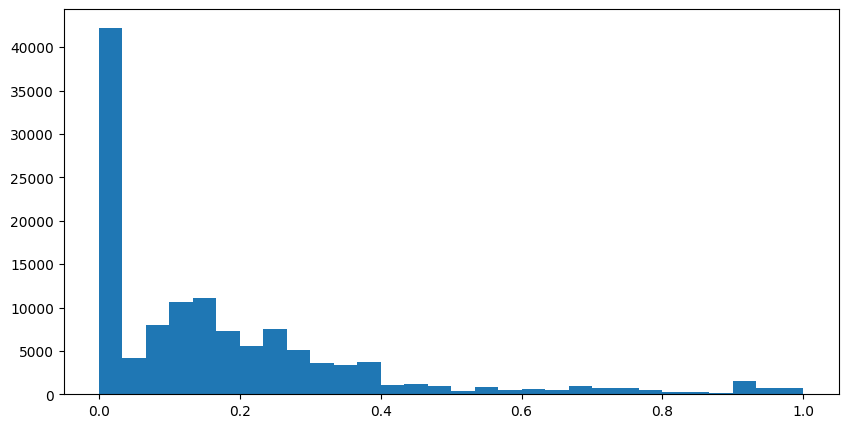

In [68]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['traceSim_values'], 30, alpha = 1, density = False)
plt.show()

#### <font color='blue'> Complete your own code here ...  </font> 

In [69]:
# With for loop method
'Complete your code here ..............'
list_traceSim_values = []

for i1 in range(len(df_distinct_stack_traces)):
    for i2 in range(i1 + 1, len(df_distinct_stack_traces)):
        list_stack_1 = df_distinct_stack_traces['listStackTrace'].iloc[i1]
        list_stack_2 = df_distinct_stack_traces['listStackTrace'].iloc[i2]
        list_traceSim_values.append(traceSim_similarity(list_stack_1, list_stack_2, dict_idf_frames, alpha=0.5, beta=0.5, gamma=0))

In [70]:
'Assert the values are correct'
assert df_measures['traceSim_values'].equals(pd.Series(list_traceSim_values))

#### <font color='blue'> Complete your own code here ...  </font> 

In [71]:
'Complete the code .............. and print 2-rounded statistics'

series_traceSim_values = pd.Series(list_traceSim_values)
attr = series_traceSim_values.describe()

print('The min values is:', round(attr['min'], 2))
print('The max values is:', round(attr['max'], 2))
print('The mean values is:', round(attr['mean'], 2))
print('The median values is:', round(attr['50%'], 2))
print('The std values is:', round(attr['std'], 2))
print('The variance values is:', round(attr['std'] ** 2, 2))

The min values is: 0.0
The max values is: 1.0
The mean values is: 0.18
The median values is: 0.12
The std values is: 0.21
The variance values is: 0.04


# C. Compare between all similarity measures

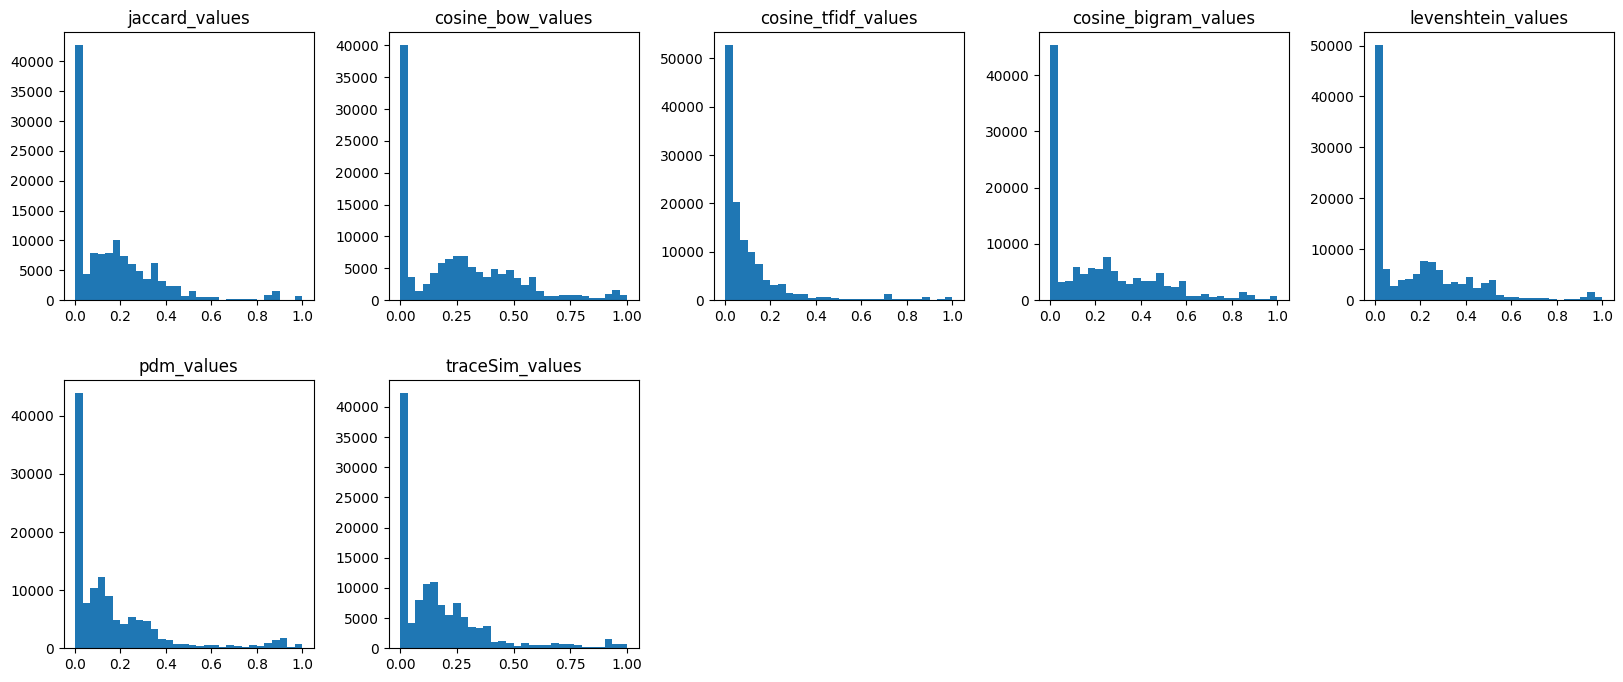

In [72]:
df_measures.iloc[:,2:].hist(grid = False, figsize = (20,8), bins = 30, layout=(2, 5))
plt.show()

In [73]:
df_measures

,index_stack_trace_1,index_stack_trace_2,jaccard_values,cosine_bow_values,cosine_tfidf_values,cosine_bigram_values,levenshtein_values,pdm_values,traceSim_values
0,0,1,0.833333,0.909091,0.868820,0.900000,0.909091,0.904573,9.413379e-01
1,0,2,0.833333,0.909091,0.868820,0.900000,0.909091,0.904573,9.413379e-01
2,0,3,0.833333,0.909091,0.868820,0.900000,0.909091,0.904573,9.413379e-01
3,0,4,0.833333,0.909091,0.868820,0.900000,0.909091,0.904573,9.413379e-01
4,0,5,0.833333,0.909091,0.868820,0.900000,0.909091,0.904573,9.413379e-01
...,...,...,...,...,...,...,...,...,...
124745,496,498,0.103448,0.277350,0.305257,0.177705,0.200000,0.403369,4.009441e-01
124746,496,499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.551115e-16
124747,497,498,0.147059,0.291667,0.060686,0.149071,0.115385,0.134792,1.442955e-01
124748,497,499,0.083333,0.125000,0.017134,0.099381,0.076923,0.035137,7.253834e-02


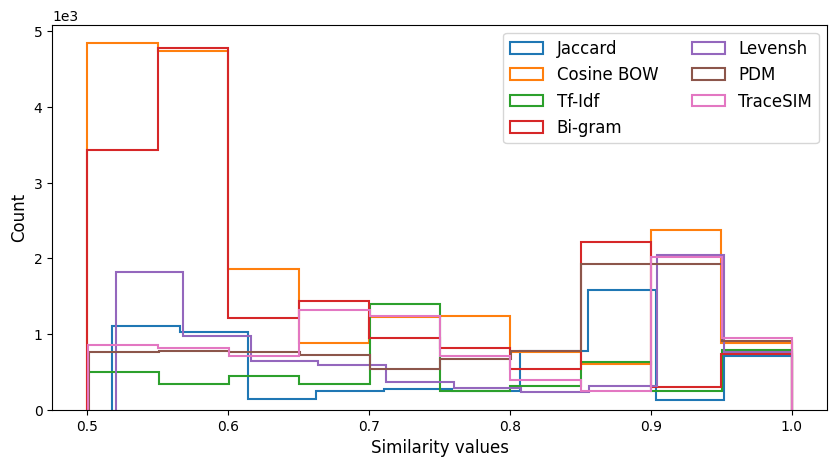

In [74]:
threshold = 0.5
linewidth = 1.5
bins = 10

df_measures[df_measures['jaccard_values'] > threshold]['jaccard_values'].hist(grid = False, histtype=u'step', label = 'Jaccard', linewidth = linewidth, bins = bins)
df_measures[df_measures['cosine_bow_values'] > threshold]['cosine_bow_values'].hist(grid = False, histtype=u'step', label = 'Cosine BOW', linewidth = linewidth, bins = bins)
df_measures[df_measures['cosine_tfidf_values'] > threshold]['cosine_tfidf_values'].hist(grid = False, histtype=u'step', label = 'Tf-Idf', linewidth = linewidth, bins = bins)
df_measures[df_measures['cosine_bigram_values'] > threshold]['cosine_bigram_values'].hist(grid = False, histtype=u'step', label = 'Bi-gram', linewidth = linewidth, bins = bins)
df_measures[df_measures['levenshtein_values'] > threshold]['levenshtein_values'].hist(grid = False, histtype=u'step', label = 'Levensh', linewidth = linewidth, bins = bins)
df_measures[df_measures['pdm_values'] > threshold]['pdm_values'].hist(grid = False, histtype=u'step', label = 'PDM', linewidth = linewidth, bins = bins)
df_measures[df_measures['traceSim_values'] > threshold]['traceSim_values'].hist(grid = False, histtype=u'step', label = 'TraceSIM', linewidth = linewidth, bins = bins)


plt.rcParams["figure.figsize"] = [10, 6]
plt.legend(loc='upper right', fontsize = 12, ncol = 2)
plt.xlabel('Similarity values', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.ticklabel_format(axis = 'y', style='', scilimits=(0,0))

## C.1. Correlation between two similarity measures

### <font color='red'> TO DO: Propose 2-3 correlation metrics to compare between two similarity metrics and then compute the correlation for all pairs and output them as a heatmap </font>

### C.1.1. Kullback–Leibler Divergence (KLD) [[doc](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)]

#### Motivation

1.0000000000000002

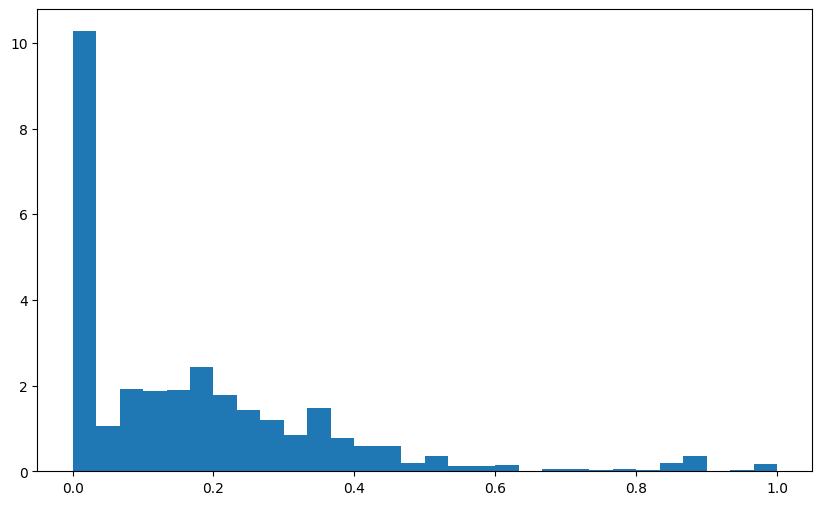

In [75]:
value_bins, bins, _ = plt.hist(df_measures['jaccard_values'], 30, alpha = 1, density = True)
proba_bins = value_bins * (1 / 30)
proba_bins.sum()

#### <font color='blue'> Complete your own code here ...  </font> 

In [76]:
def KL(values1, values2, n_bins):
    value_bins1, bins1, _ = plt.hist(values1, n_bins, alpha = 1, density = True)
    proba_bins1 = value_bins1 * (1 / n_bins)
    value_bins2, bins2, _ = plt.hist(values2, n_bins, alpha = 1, density = True)
    proba_bins2 = value_bins2 * (1 / n_bins)
    sum = 0
    for i in range(len(proba_bins1)):
        val = 0
        if (proba_bins1[i] > 0 or proba_bins1[i] < 0): val = np.log(proba_bins1[i]/proba_bins2[i])
        sum += proba_bins1[i] * val    
    return sum

### Example : Jaccard and PDM

0.08440436661154735

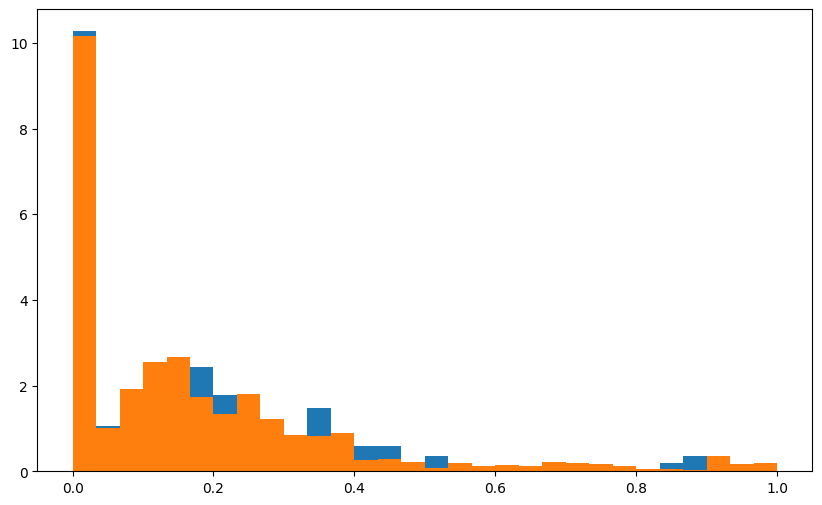

In [77]:
"The output must be ~ 0.085 "
KL(df_measures['jaccard_values'], df_measures['traceSim_values'], 30)

#### <font color='red'> TO DO : Take the values that are higher than a specific threshold for at least one measure </font>

In [78]:
df_tmp = df_measures[['jaccard_values','traceSim_values']]
df_tmp.head()

,jaccard_values,traceSim_values
0,0.833333,0.941338
1,0.833333,0.941338
2,0.833333,0.941338
3,0.833333,0.941338
4,0.833333,0.941338


In [79]:
'Filter the values that are greater than 0.5 for at least one measure'
threshold = 0.5
df_tmp = df_tmp[(df_tmp.T > threshold).any()]
df_tmp.head()

,jaccard_values,traceSim_values
0,0.833333,0.941338
1,0.833333,0.941338
2,0.833333,0.941338
3,0.833333,0.941338
4,0.833333,0.941338


0.5665380992395948

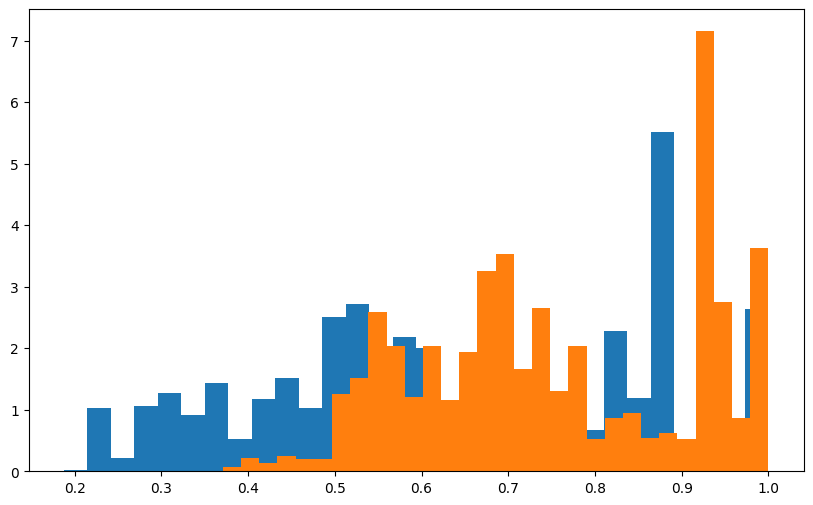

In [80]:
"The output must be ~ 0.58 "
KL(df_tmp['jaccard_values'], df_tmp['traceSim_values'], 30)

#### <font color='blue'> Complete your own code here ...  </font> 

In [81]:
'Impelement a version of KLD with threshold'
def KL_with_threshold(values1, values2, n_bins, threshold): 
    'Complete your code here .....................'
    df_tmp = pd.DataFrame(data=[values1, values2]).transpose()
    df_tmp = df_tmp[(df_tmp.T > threshold).any()]
    return KL(df_tmp.iloc[:, 0], df_tmp.iloc[:, 1], n_bins)

0.5665380992395948

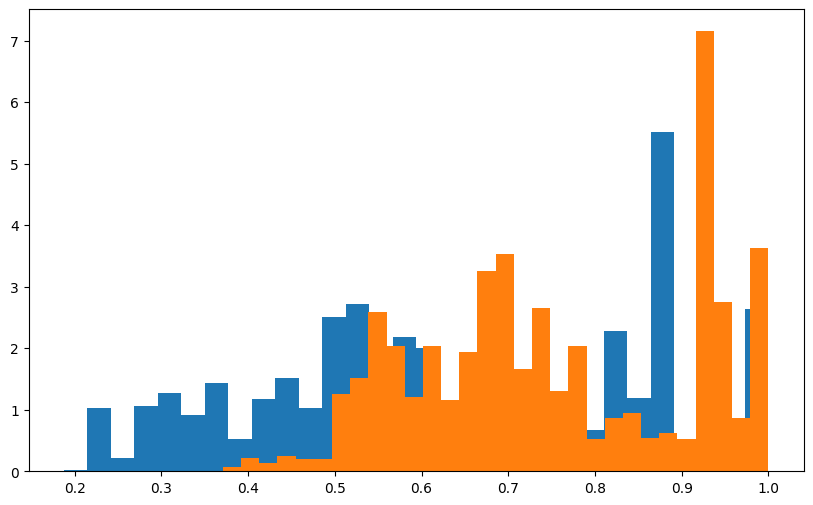

In [82]:
"The output must be ~ 0.58 "
KL_with_threshold(df_measures['jaccard_values'], df_measures['traceSim_values'], 30, 0.5)

## All similarity pairs

#### <font color='blue'> Complete your own code here ...  </font> 

In [83]:
'Output a matrix where lines and columns are similarity measures and the matrix values are the correlation between similarity metric pairs'
def matrix_correlation_kld(df_measures, n_bins, threshold) :
    correlation_matrix = np.zeros((len(df_measures.columns)-2, len(df_measures.columns)-2), float)
    'Complete your code here .......................................'
    for i, row_label in enumerate(df_measures.columns[2:]):
        row_values = df_measures[row_label]
        for j, col_label in enumerate(df_measures.columns[2:]):
            col_values = df_measures[col_label]
            correlation_matrix[i][j] = KL_with_threshold(row_values, col_values, n_bins, threshold)
    return correlation_matrix

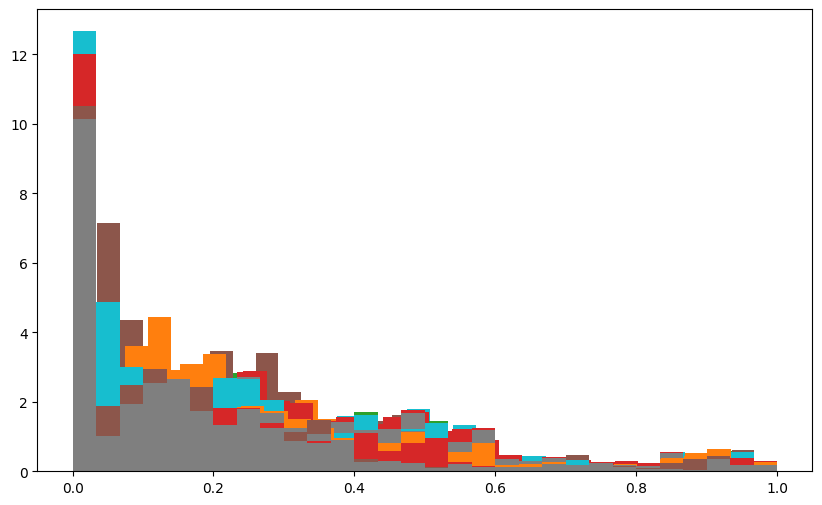

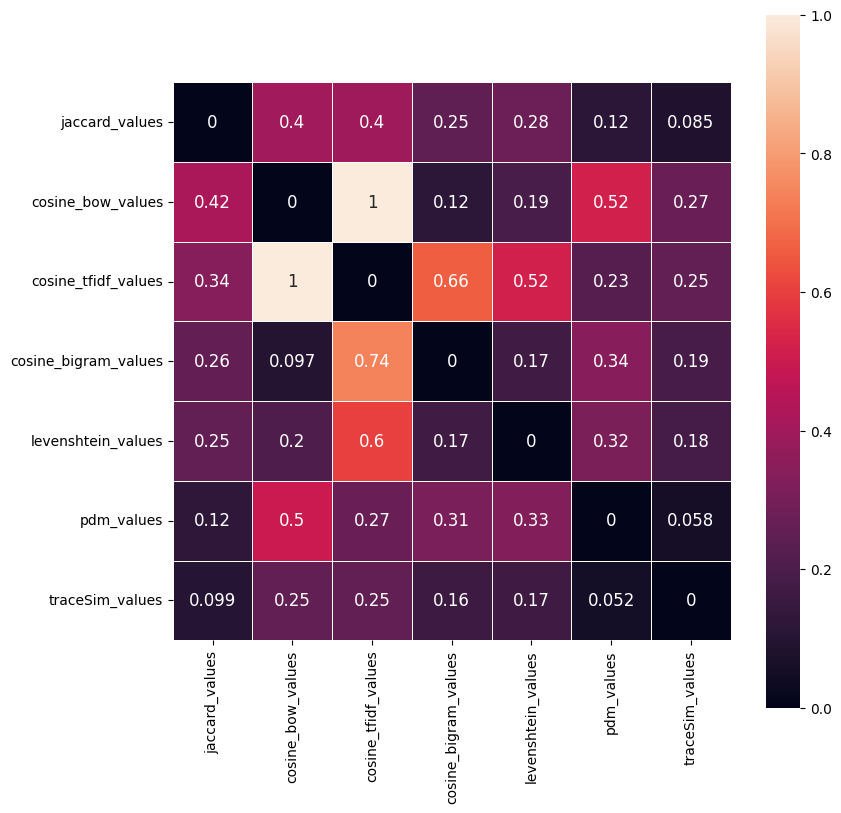

In [84]:
threshold = 0
correlation_kld_matrix = matrix_correlation_kld(df_measures, 30, threshold)
columns = list(df_measures.columns[2:])
f, ax = plt.subplots(figsize=(9, 9))
ax = sns.heatmap(correlation_kld_matrix, vmin = 0, vmax=1, linewidths=.5, square=True, annot=True, xticklabels = columns, yticklabels = columns, annot_kws={"size": 12})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)
plt.show()

Ur result must match:
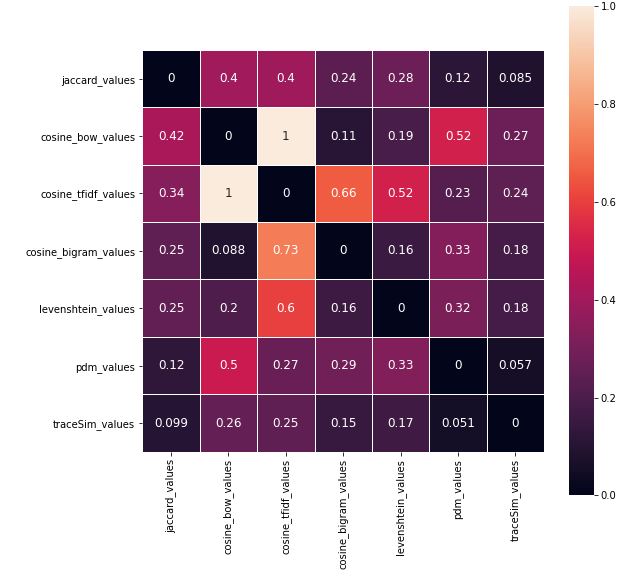

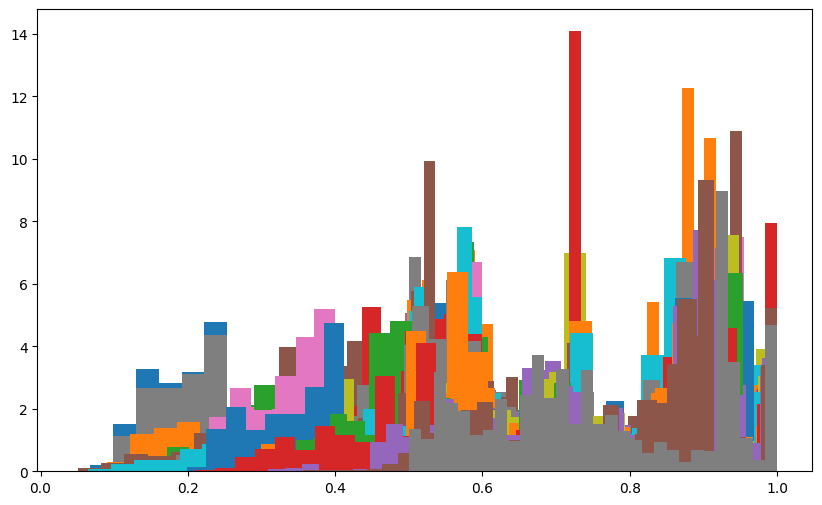

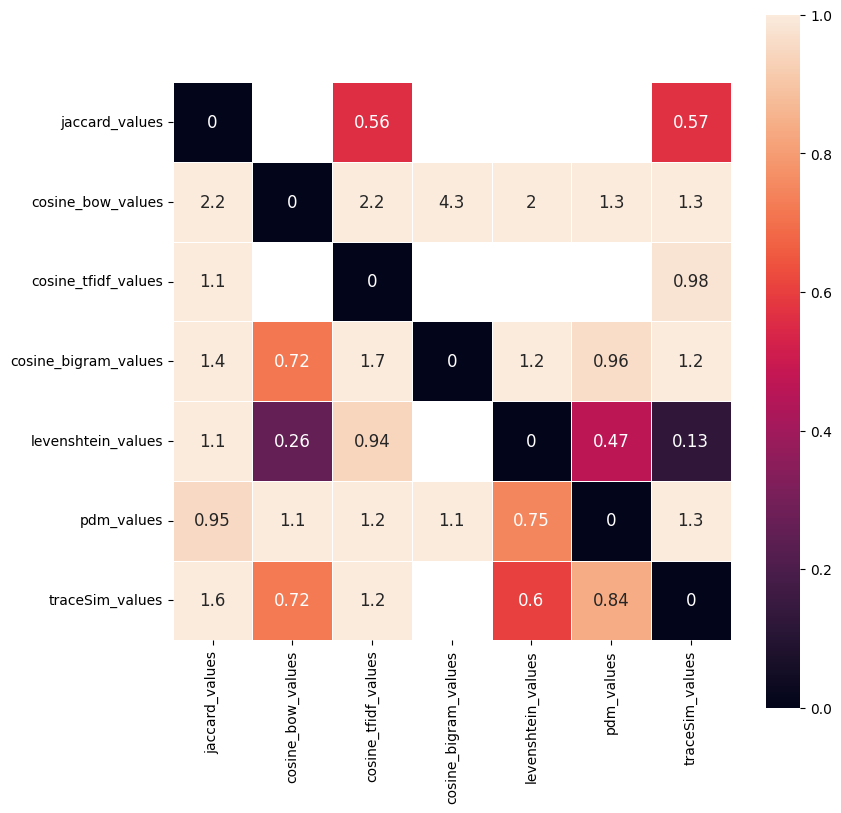

In [85]:
threshold = 0.5
correlation_kld_matrix = matrix_correlation_kld(df_measures, 30, threshold)
columns = list(df_measures.columns[2:])
f, ax = plt.subplots(figsize=(9, 9))
ax = sns.heatmap(correlation_kld_matrix, vmin = 0, vmax=1, linewidths=.5, square=True, annot=True, xticklabels = columns, yticklabels = columns, annot_kws={"size": 12})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)
plt.show()

Ur result must match:
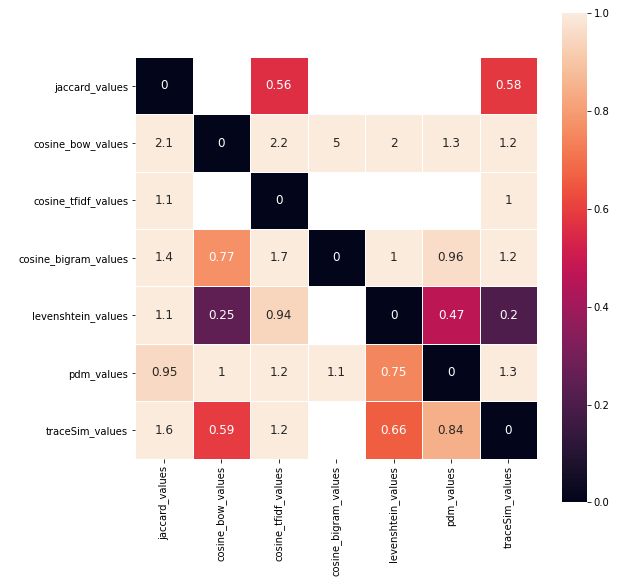

### C.1.2. Correlation of Pearson [[doc](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)]

#### <font color='blue'> Complete your own code here ...  </font> 

In [86]:
from scipy import stats
def pearson_correlation (values1, values2):
    'Complete your code here ..................................'
    corr, _ = stats.pearsonr(values1, values2)
    return corr

def pearson_correlation_with_threshold (values1, values2, threshold):
    'Complete your code here ..................................'
    df_tmp = pd.DataFrame(data=[values1, values2]).transpose()
    df_tmp = df_tmp[(df_tmp.T > threshold).any()]
    return pearson_correlation(df_tmp.iloc[:, 0], df_tmp.iloc[:, 1])


def matrix_correlation_pearson(df_measures, threshold) :
    correlation_matrix = np.zeros((len(df_measures.columns)-2, len(df_measures.columns)-2), float)
    'Complete your code here ..................................'
    for i, row_label in enumerate(df_measures.columns[2:]):
        row_values = df_measures[row_label]
        for j, col_label in enumerate(df_measures.columns[2:]):
            col_values = df_measures[col_label]
            correlation_matrix[i][j] = pearson_correlation_with_threshold(row_values, col_values, threshold)
    return correlation_matrix

In [87]:
"The output must be ~ 0.95 "
pearson_correlation(df_measures['jaccard_values'], df_measures['cosine_bow_values'])

0.9596646036432839

In [88]:
"The output must be ~ 0.93 "
pearson_correlation_with_threshold(df_measures['jaccard_values'], df_measures['cosine_bow_values'], 0.5)

0.9305866249201162

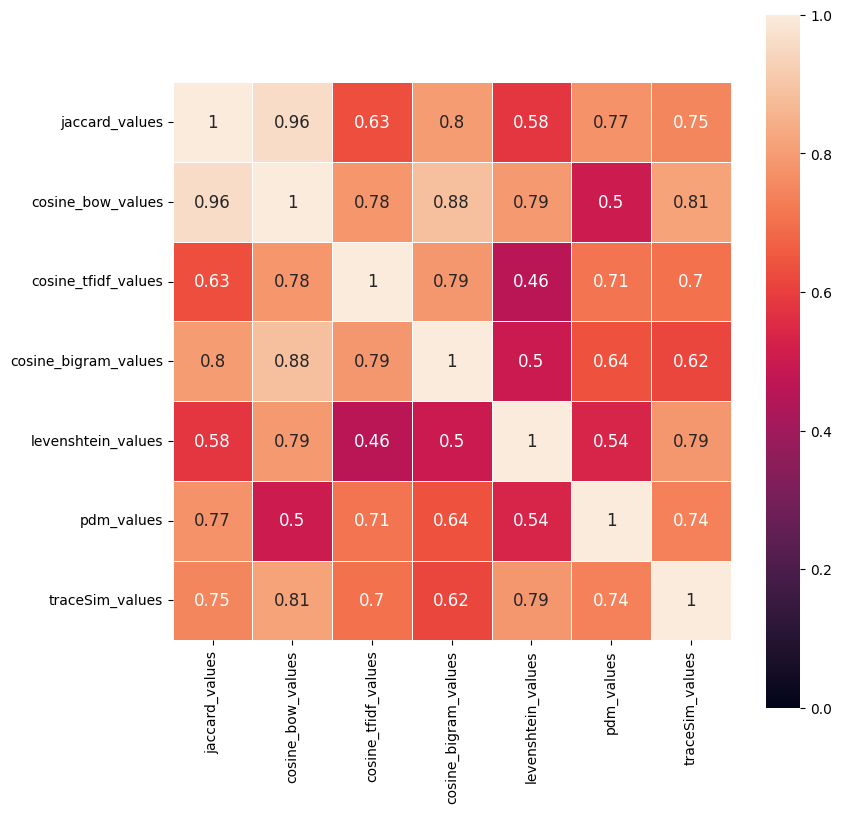

In [89]:
threshold = 0.8
correlation_pearson_matrix = matrix_correlation_pearson(df_measures,threshold)
columns = list(df_measures.columns[2:])
f, ax = plt.subplots(figsize=(9, 9))
ax = sns.heatmap(correlation_pearson_matrix, vmin = 0, vmax=1, linewidths=.5, square=True, annot=True, xticklabels = columns, yticklabels = columns, annot_kws={"size": 12})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)
plt.show()

Ur result must match:
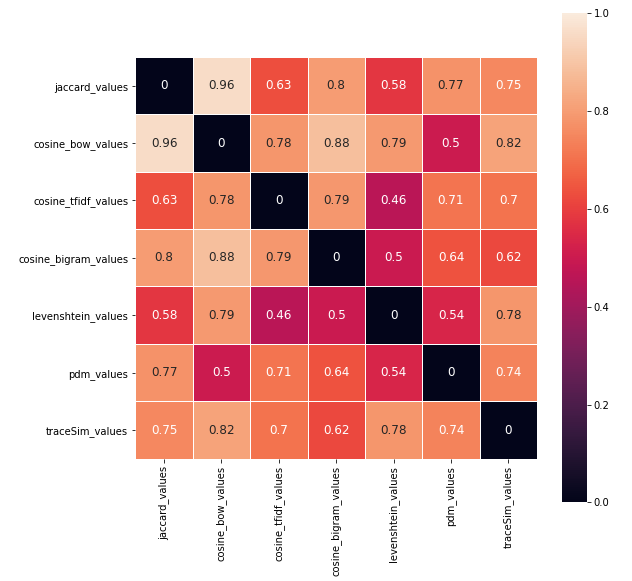

### <font color='red'> C.1.3. Correlation of Spearman [[doc](https://statistics.laerd.com/statistical-guides/spearmans-rank-order-correlation-statistical-guide.php#:~:text=Spearman's%20correlation%20measures%20the%20strength,is%20monotonic%2C%20but%20not%20linear.)] </font>

#### <font color='blue'> Complete your own code here ...  </font> 

In [90]:
from scipy import stats
'Change yourMeasure with the name of your measure'

def spearman_correlation (values1, values2):
    'Complete your code here ..................................'
    corr, _ = stats.spearmanr(values1, values2)
    return corr


def spearman_correlation_with_threshold (values1, values2, threshold):
    'Complete your code here ..................................'
    df_tmp = pd.DataFrame(data=[values1, values2]).transpose()
    df_tmp = df_tmp[(df_tmp.T > threshold).any()]
    return spearman_correlation(df_tmp.iloc[:, 0], df_tmp.iloc[:, 1])

def matrix_correlation_spearman(df_measures, threshold) :
    correlation_matrix = np.zeros((len(df_measures.columns)-2, len(df_measures.columns)-2), float)
    'Complete your code here ..................................'
    for i, row_label in enumerate(df_measures.columns[2:]):
        row_values = df_measures[row_label]
        for j, col_label in enumerate(df_measures.columns[2:]):
            col_values = df_measures[col_label]
            correlation_matrix[i][j] = spearman_correlation_with_threshold(row_values, col_values, threshold)
    return correlation_matrix

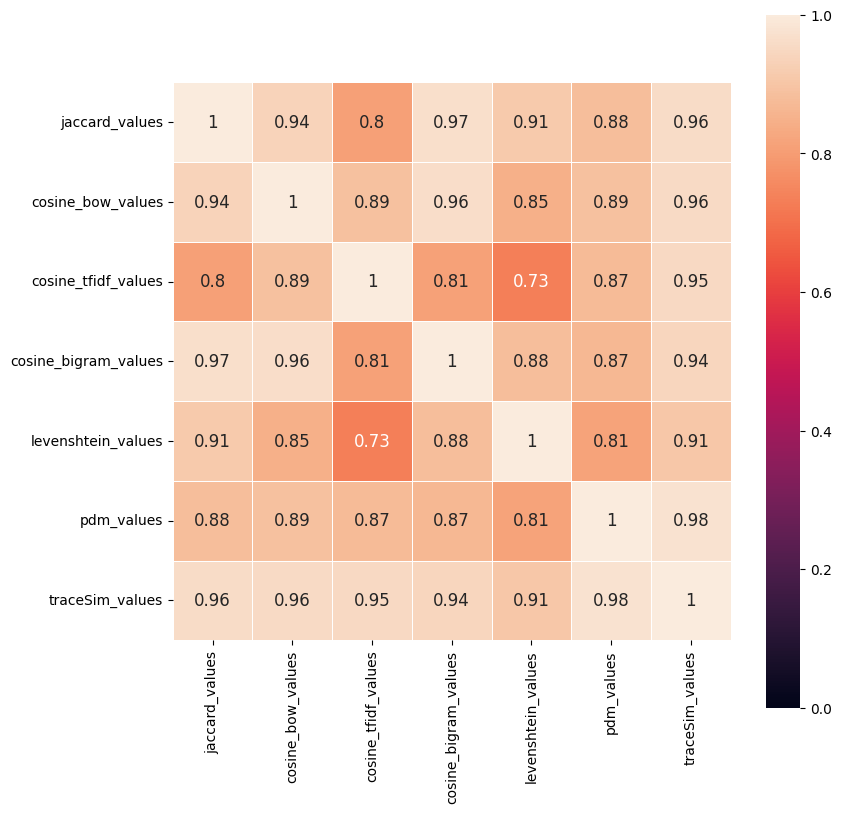

In [91]:
threshold = 0.0
correlation_spearman_matrix = matrix_correlation_spearman(df_measures,threshold)
columns = list(df_measures.columns[2:])
f, ax = plt.subplots(figsize=(9, 9))
ax = sns.heatmap(correlation_spearman_matrix, vmin = 0, vmax=1, linewidths=.5, square=True, annot=True, xticklabels = columns, yticklabels = columns, annot_kws={"size": 12})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)
plt.show()

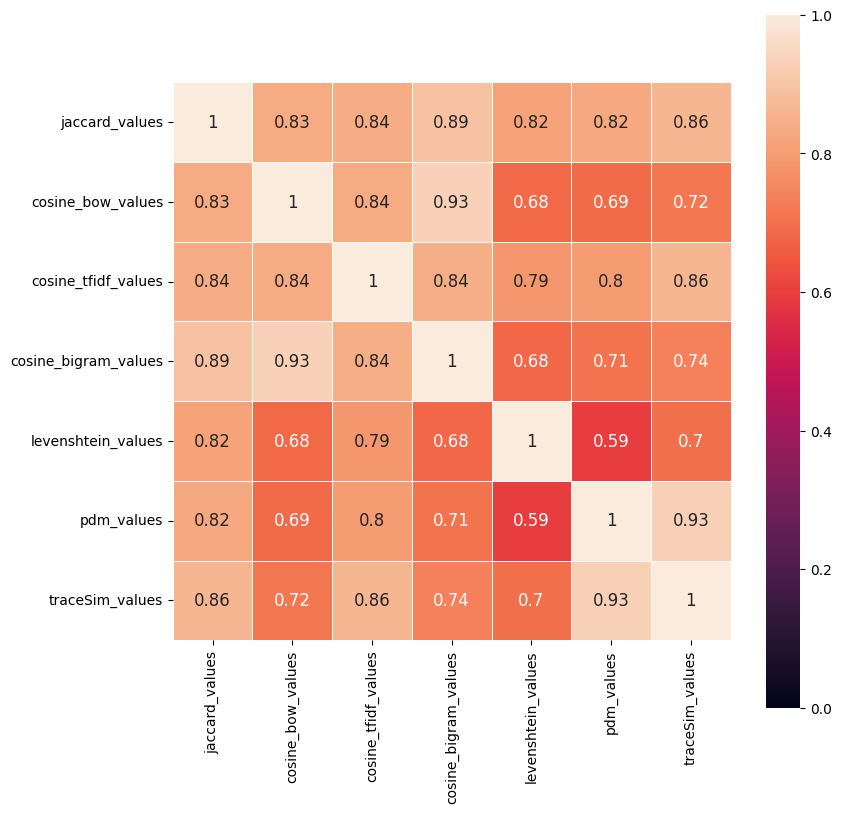

In [92]:
threshold = 0.5
correlation_spearman_matrix = matrix_correlation_spearman(df_measures,threshold)
columns = list(df_measures.columns[2:])
f, ax = plt.subplots(figsize=(9, 9))
ax = sns.heatmap(correlation_spearman_matrix, vmin = 0, vmax=1, linewidths=.5, square=True, annot=True, xticklabels = columns, yticklabels = columns, annot_kws={"size": 12})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)
plt.show()

## C.2. Inspect individuel cases

We computed 2 functions to display the differences between 2 stacktraces in terms of frames that differ: 

In [93]:
import difflib
def from_list_to_file(lista, name):
    textfile = open(name, "w")
    for element in lista:
        textfile.write(element + "\n")
    textfile.close()
def compare_files(rute_1, rute_2):
    
    with open(rute_1) as file_1:
        file_1_text = file_1.readlines()

    with open(rute_2) as file_2:
        file_2_text = file_2.readlines()

    for line in difflib.context_diff(
        file_1_text, file_2_text, fromfile='file1.txt',
        tofile='file2.txt', lineterm=''
    ):
        print(line)    


### <font color='red'> For similarity measures that are not highly correlated display a scatter graph, then show the outlying individual cases and justify why, based on the properties of the similarity measures (take at least 3 cases)  </font>

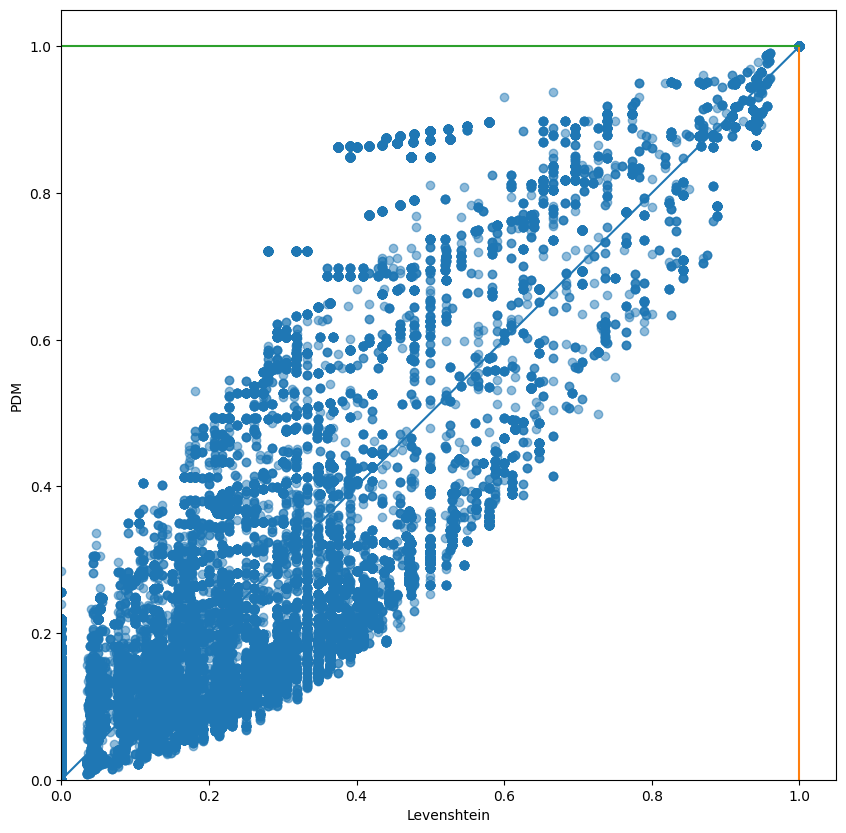

In [94]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.scatter(df_measures['levenshtein_values'], df_measures['pdm_values'], alpha=0.5)
plt.xlabel("Levenshtein")
plt.ylabel("PDM")
plt.plot([0,1],[0,1])
plt.plot([1,1],[0,1])
plt.plot([0,1],[1,1])
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.show()

In [95]:
df_measures[(df_measures['levenshtein_values'] < 0.4) & (df_measures['pdm_values'] > 0.8)].sort_values(by='pdm_values')[['index_stack_trace_1','index_stack_trace_2','levenshtein_values','pdm_values']]

,index_stack_trace_1,index_stack_trace_2,levenshtein_values,pdm_values
38,0,39,0.391304,0.849206
15292,31,320,0.391304,0.849206
15011,31,39,0.391304,0.849206
12469,25,320,0.391304,0.849206
12188,25,39,0.391304,0.849206
...,...,...,...,...
3382,6,410,0.391304,0.864295
19549,40,410,0.391304,0.864295
19518,40,379,0.391304,0.864295
9189,18,379,0.391304,0.864295


In [96]:
print(df_distinct_stack_traces['stackTrace'][0])
print(df_distinct_stack_traces['stackTrace'][39])

class java.lang.Exception : null
at com.myCompany.core.client.Application.createErrorDialog(Application.java:1176)
at com.myCompany.core.client.Application.access$3(Application.java:1172)
at com.myCompany.core.client.Application$6.run(Application.java:1588)
at org.eclipse.swt.widgets.RunnableLock.run(RunnableLock.java:35)
at org.eclipse.swt.widgets.Synchronizer.runAsyncMessages(Synchronizer.java:135)
at org.eclipse.swt.widgets.Display.runAsyncMessages(Display.java:4144)
at org.eclipse.swt.widgets.Display.readAndDispatch(Display.java:3761)
at org.eclipse.jface.window.Window.runEventLoop(Window.java:825)
at org.eclipse.jface.window.Window.open(Window.java:801)
at com.myCompany.core.client.Application.run(Application.java:1098)
at com.myCompany.achatsventes.client.VentesApp.main(VentesApp.java:33)

class java.lang.Exception : null
at com.myCompany.core.client.Application.createErrorDialog(Application.java:1110)
at com.myCompany.core.client.Application.access$3(Application.java:1106)
at co

In [97]:
df_distinct_stack_traces['listStackTrace'][0][0:9] == df_distinct_stack_traces['listStackTrace'][39][0:9]

True

![image](stacktraces_examples/stack1.PNG)

For the stacktraces 0 and 39, the first 9 frames are identical. From the 10th frame on, they differ. PDM gives more weight for the frames closer to the top. It also puts more emphasis on matched frames and that's why we get a high value for the similarity. The Levenshtein value is small because one stacktrace is significantly longer than the other and it requires lots of edit operations.

#### <font color='blue'> Complete explanation here ...  </font> 

We can see some points in the scatter plot that are not higly correlated. Some of these points are especially for the part of the plot where `df_measures['levenshtein_values'] < 0.4` and `df_measures['pdm_values'] > 0.8`. This makes a total of at least 287 values out of 124750 that are higly uncorrelated.

The PDM similarity considers the position of a certain frame with respect to the top as a weight. The closer a frame is to the top, the bigger the weight is. It also considers the distance between 2 matched frames in the 2 different stack traces. 

On the other hand, Levenshtein's distance just considers the number of operations required to convert one stack trace into the other one, not taking into account the offsets or any reference inside the stack trace (e.g. distance to the top) itself. 

Other higly uncorrelated similarities according to the heat maps are for example `Trace SIM - Cosine TF-IDF`, `Cosine TF-IDF - Cosine Bigram` and `Jaccard - Cosine BOW`. Let's have a look at their scatter plots:

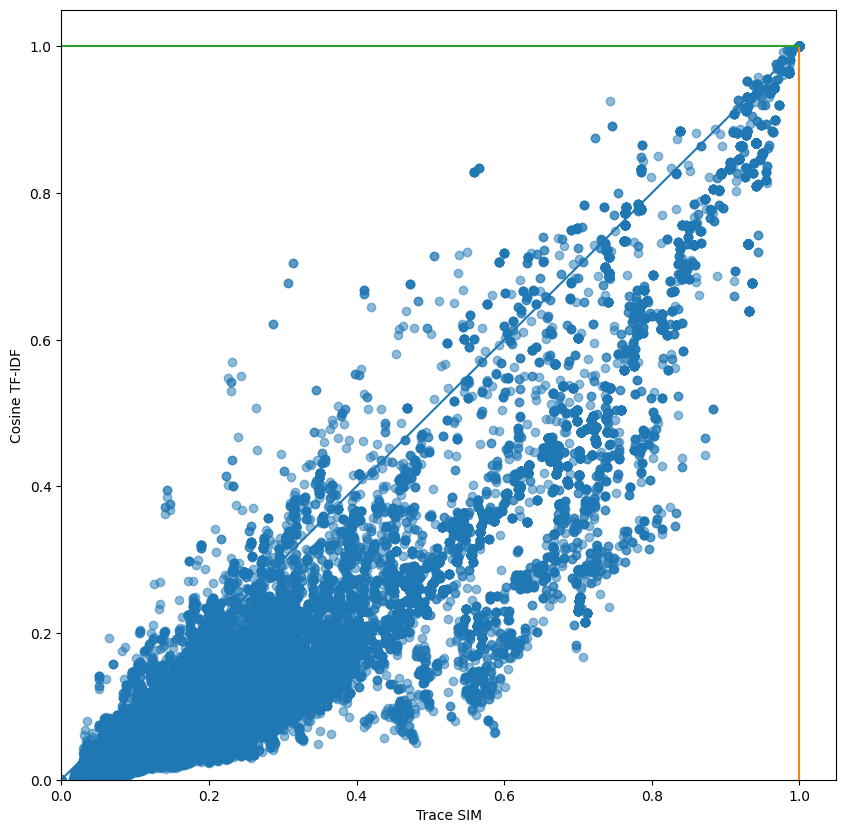

In [98]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.scatter(df_measures['traceSim_values'], df_measures['cosine_tfidf_values'], alpha=0.5)
plt.xlabel("Trace SIM")
plt.ylabel("Cosine TF-IDF")
plt.plot([0,1],[0,1])
plt.plot([1,1],[0,1])
plt.plot([0,1],[1,1])
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.show()

In [99]:
df_measures[(df_measures['traceSim_values'] > 0.6) & (df_measures['cosine_tfidf_values'] < 0.3)].sort_values(by='cosine_tfidf_values')[['index_stack_trace_1','index_stack_trace_2','traceSim_values','cosine_tfidf_values']]

,index_stack_trace_1,index_stack_trace_2,traceSim_values,cosine_tfidf_values
101969,286,297,0.601103,0.126944
101565,284,320,0.605527,0.150787
108710,320,391,0.608994,0.165525
47542,106,320,0.607143,0.165823
57042,131,320,0.608102,0.167537
...,...,...,...,...
29140,62,156,0.669069,0.299206
44627,99,177,0.669069,0.299206
21266,44,301,0.669664,0.299994
21154,44,189,0.669664,0.299994


We can see some points in the scatter plot that are not higly correlated. Some of these points are especially for the part of the plot where `df_measures['traceSim_values'] > 0.6` and `df_measures['cosine_tfidf_values'] < 0.3`. This makes a total of at least 580 values out of 124750 that are higly uncorrelated.

TF-IDF only considers frame frequencies. The TF component is a local frequency of a frame, while the IDF is a scale factor that decreases the "importance" of a frame if it is very frequent on a global level, in multiple stacktraces. 

TraceSim uses local and global information for each frame (in the form of weights) as well. The difference is that for the local part, it only considers the distance of a frame to the top. For the global level it coincides with TF-IDF, as it uses a tuned value of IDF. The main difference is that TraceSim uses the weights through a modified Levenshtein approach, scaling the weights of the Edit operations.

In [100]:
print(df_distinct_stack_traces['stackTrace'][286])
print(df_distinct_stack_traces['stackTrace'][297])

class java.lang.Exception : null
at com.myCompany.core.client.Application.createErrorDialog(Application.java:1092)
at com.myCompany.core.client.Application.access$3(Application.java:1088)
at com.myCompany.core.client.Application$6.run(Application.java:1509)
at org.eclipse.swt.widgets.RunnableLock.run(RunnableLock.java:35)
at org.eclipse.swt.widgets.Synchronizer.runAsyncMessages(Synchronizer.java:135)
at org.eclipse.swt.widgets.Display.runAsyncMessages(Display.java:3529)
at org.eclipse.swt.widgets.Display.readAndDispatch(Display.java:3182)
at org.eclipse.jface.window.Window.runEventLoop(Window.java:825)
at org.eclipse.jface.window.Window.open(Window.java:801)
at com.myCompany.superviseur.client.modules.postpreparation.common.ImprEtiquetteDeporteHelper.blocageWithPopup(ImprEtiquetteDeporteHelper.java:255)
at com.myCompany.superviseur.client.modules.postpreparation.common.ImprEtiquetteDeporteHelper.checkChargeImpression(ImprEtiquetteDeporteHelper.java:185)
at com.myCompany.superviseur.cli

In [101]:
df_distinct_stack_traces['listStackTrace'][286][0:9] == df_distinct_stack_traces['listStackTrace'][297][0:9]

True

![image](stacktraces_examples/stack2.PNG)

For the stacktraces 286 and 297, the first 10 frames are identical. From the 11th frame on, they differ. 

Both Cosine TF-IDF and Trace SIM use frequencies on a a global level, but Trace SIM gives more weight for the first 10 frames thanks to the modified Levenshtein. This is why we have higher values for the Traces SIM similarity.

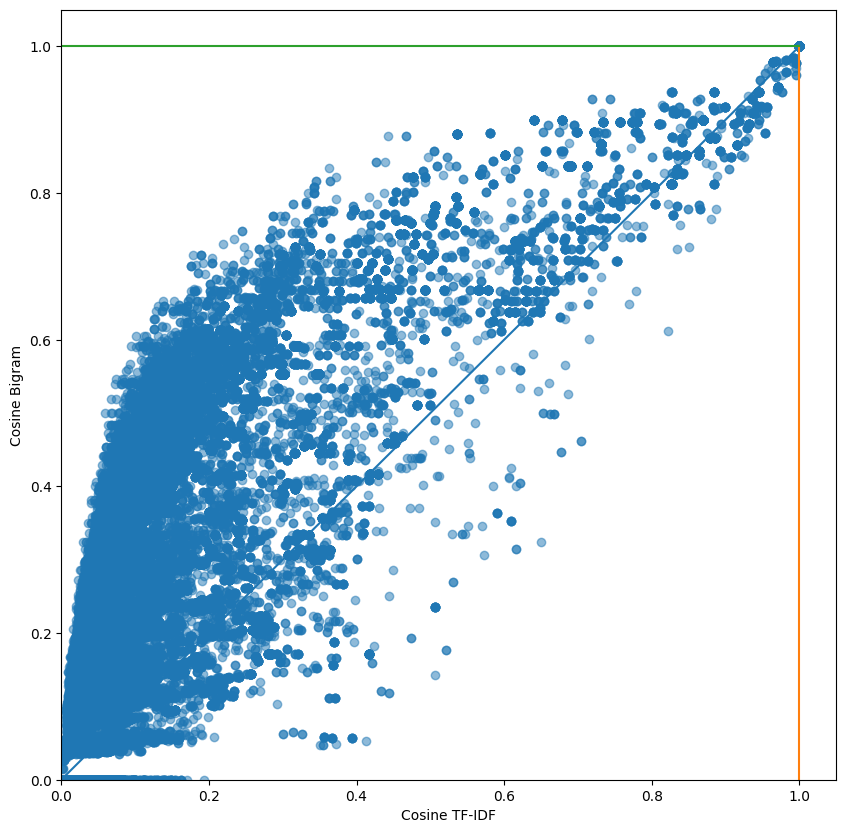

In [102]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.scatter(df_measures['cosine_tfidf_values'], df_measures['cosine_bigram_values'], alpha=0.5)
plt.xlabel("Cosine TF-IDF")
plt.ylabel("Cosine Bigram")
plt.plot([0,1],[0,1])
plt.plot([1,1],[0,1])
plt.plot([0,1],[1,1])
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.show()

In [103]:
df_measures[(df_measures['cosine_tfidf_values'] < 0.3) & (df_measures['cosine_bigram_values'] > 0.6)].sort_values(by='cosine_bigram_values')[['index_stack_trace_1','index_stack_trace_2','cosine_tfidf_values','cosine_bigram_values']]

,index_stack_trace_1,index_stack_trace_2,cosine_tfidf_values,cosine_bigram_values
116109,368,374,0.227454,0.600099
116156,368,421,0.227454,0.600099
34150,73,425,0.234678,0.600099
64990,153,425,0.234678,0.600099
121681,421,434,0.182650,0.600099
...,...,...,...,...
108729,320,410,0.285010,0.750000
102834,290,320,0.287313,0.768376
108693,320,374,0.287498,0.768376
108740,320,421,0.287498,0.768376


We can see some points in the scatter plot that are not higly correlated. Some of these points are especially for the part of the plot where `df_measures['cosine_tfidf_values'] < 0.3` and `df_measures['cosine_bigram_values'] > 0.6`. This makes a total of at least 1177 values out of 124750 that are higly uncorrelated.

Both Cosine TF-IDF and Cosine Bigram consider frame frequencies, but TF-IDF takes into account the frequency both locally and globally and it decreases the importance of a frame that is more frequent on a global level, while the Cosine Bigrams only calculates the frequency of a bigram in an exact stacktrace, so locally. Also, the Cosine Bigram considers the order for bigrams partially, while Cosine TF-IDF doesn't consider order at all. This is the main source of high uncorrelation.  

The low value of TF-IDF could be due to the fact that we find frames in the 2 stacktraces that are frequent on a global level. Because the Cosine Bigram only considers local frequency, we get a high value for the similarity.

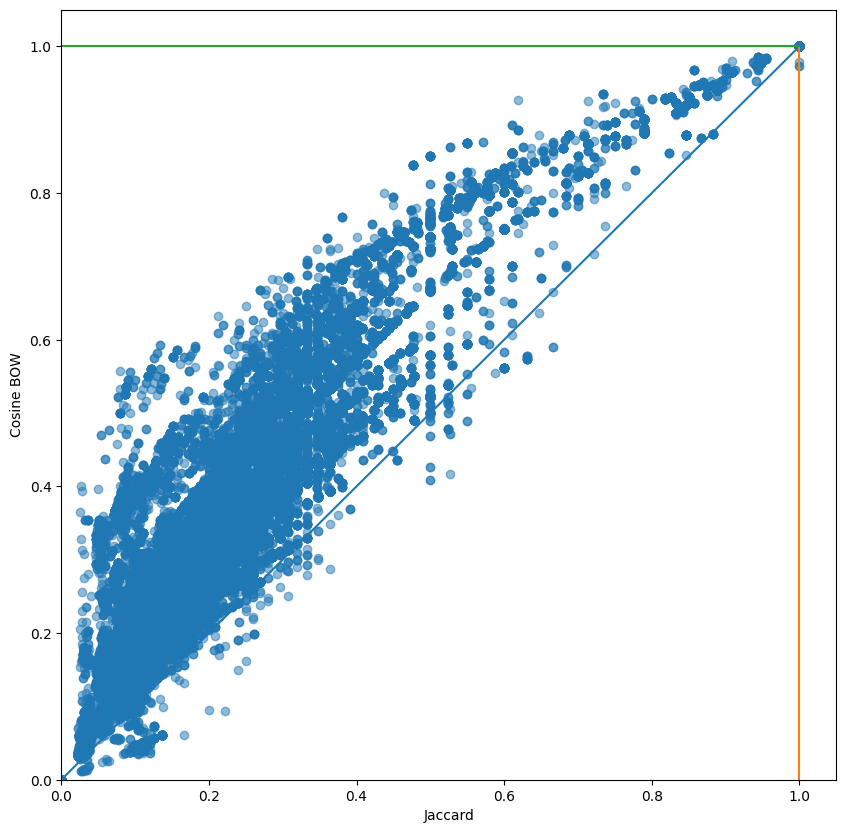

In [104]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.scatter(df_measures['jaccard_values'], df_measures['cosine_bow_values'], alpha=0.5)
plt.xlabel("Jaccard")
plt.ylabel("Cosine BOW")
plt.plot([0,1],[0,1])
plt.plot([1,1],[0,1])
plt.plot([0,1],[1,1])
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.show()

In [105]:
df_measures[(df_measures['jaccard_values'] < 0.2) & (df_measures['cosine_bow_values'] > 0.4)].sort_values(by='cosine_bow_values')[['index_stack_trace_1','index_stack_trace_2','jaccard_values','cosine_bow_values']]

,index_stack_trace_1,index_stack_trace_2,jaccard_values,cosine_bow_values
90301,237,242,0.113636,0.400047
65152,154,242,0.113636,0.400047
50728,114,398,0.142857,0.400047
91622,242,268,0.113636,0.400047
76863,190,199,0.090909,0.400066
...,...,...,...,...
40084,88,89,0.181818,0.589256
110560,331,338,0.181818,0.590839
28447,60,338,0.181818,0.590839
66958,159,338,0.133333,0.593296


We can see some points in the scatter plot that are not higly correlated. Some of these points are especially for the part of the plot where `df_measures['jaccard_values'] < 0.2` and `df_measures['cosine_bow_values'] > 0.4`. This makes a total of at least 968 values out of 124750 that are higly uncorrelated.

The main difference between the Jaccard and Cosine BOW similarities is that Jaccard considers the frames of the stacktraces as sets, which means that it doesn't take into account repetitions. On the other hand, Cosine BOW does take into consideration the frequency of the frame in each stacktrace. 

In [106]:
print(df_distinct_stack_traces['stackTrace'][154])
print(df_distinct_stack_traces['stackTrace'][242])

class java.lang.NullPointerException : null
at com.myCompany.superviseur.client.modules.postpreparation.prepprep.console.FnManager.canQuit(FnManager.java:1297)
at com.myCompany.superviseur.client.modules.postpreparation.prepprep.PrepPrepVC.handleQuit(:455)
at com.myCompany.superviseur.client.modules.postpreparation.prepprep.PrepPrepVC.handleAction(:2911)
at com.myCompany.superviseur.client.modules.postpreparation.tools.action.ActionHelper$1.run(ActionHelper.java:220)
at org.eclipse.jface.action.Action.runWithEvent(Action.java:498)
at com.myCompany.core.client.modules.window.ActionHandler.runAction(ActionHandler.java:143)
at com.myCompany.core.client.modules.window.ActionHandler.handleEvent(ActionHandler.java:118)
at org.eclipse.swt.widgets.EventTable.sendEvent(EventTable.java:84)
at org.eclipse.swt.widgets.Display.filterEvent(Display.java:1483)
at org.eclipse.swt.widgets.Widget.sendEvent(Widget.java:1275)
at org.eclipse.swt.widgets.Widget.sendEvent(Widget.java:1300)
at org.eclipse.swt.

In [107]:
from collections import Counter

set_a = set(df_distinct_stack_traces['listStackTrace'][237])
set_b = set(df_distinct_stack_traces['listStackTrace'][242])

a = Counter(df_distinct_stack_traces['listStackTrace'][237])
b = Counter(df_distinct_stack_traces['listStackTrace'][242])

print('These are the common frames:')
print(set_a.intersection(set_b))
print('Number of common frames:', len(set_a.intersection(set_b)))

print()
print('Frames that appear multiple times in stack trace 237')
for e in a:
    if a[e] > 1:
        print(e, '-> Number of appearances:', a[e])
print()

print('Frames that appear multiple times in stack trace 242')
for e in b:
    if b[e] > 1:
        print(e, '-> number of appearances:', b[e])


These are the common frames:
{'org.eclipse.swt.widgets.EventTable.sendEvent', 'org.eclipse.swt.widgets.TypedListener.handleEvent', 'org.eclipse.swt.widgets.Display.windowProc', 'org.eclipse.swt.widgets.Control.windowProc', 'org.eclipse.swt.widgets.Widget.sendEvent'}
Number of common frames: 5

Frames that appear multiple times in stack trace 237
org.eclipse.swt.widgets.Widget.sendEvent -> Number of appearances: 3

Frames that appear multiple times in stack trace 242
org.eclipse.swt.widgets.Widget.sendEvent -> number of appearances: 3


The stackTraces 237 and 242 both have duplicate frames ('org.eclipse.swt.widgets.Widget.sendEvent' appears 3 times in each stackTrace). But as Jaccard Similarity calculates with sets, these duplicates are not taken into account, therefore the Jaccard similarity value is lower for these stackTraces. The Cosine BOW Similarity does take the duplicates into account when calculating the similarity, so the cosine bow similarity value is higher, as also the duplicated frames are counted, so the number of similar frames is higher.

## C.3. Properties of similarity measures

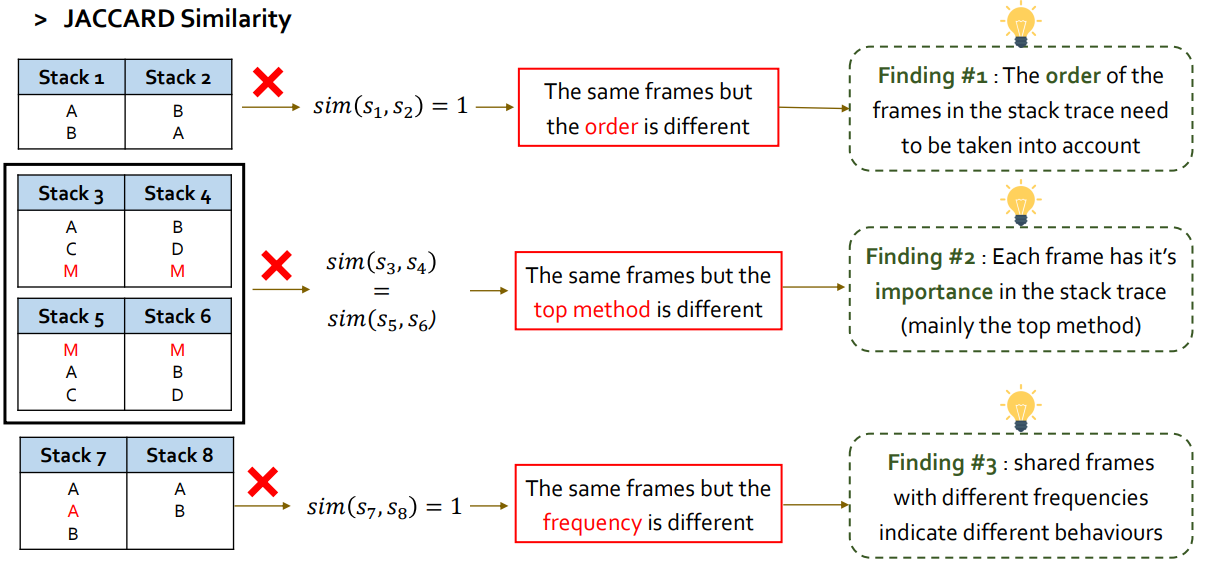

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

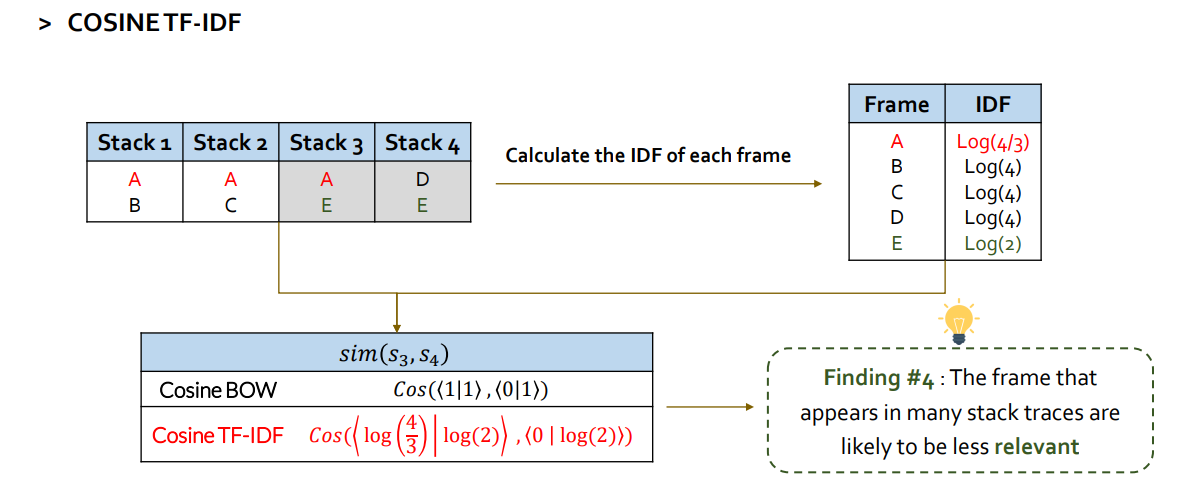

-----------------------------------------------------------

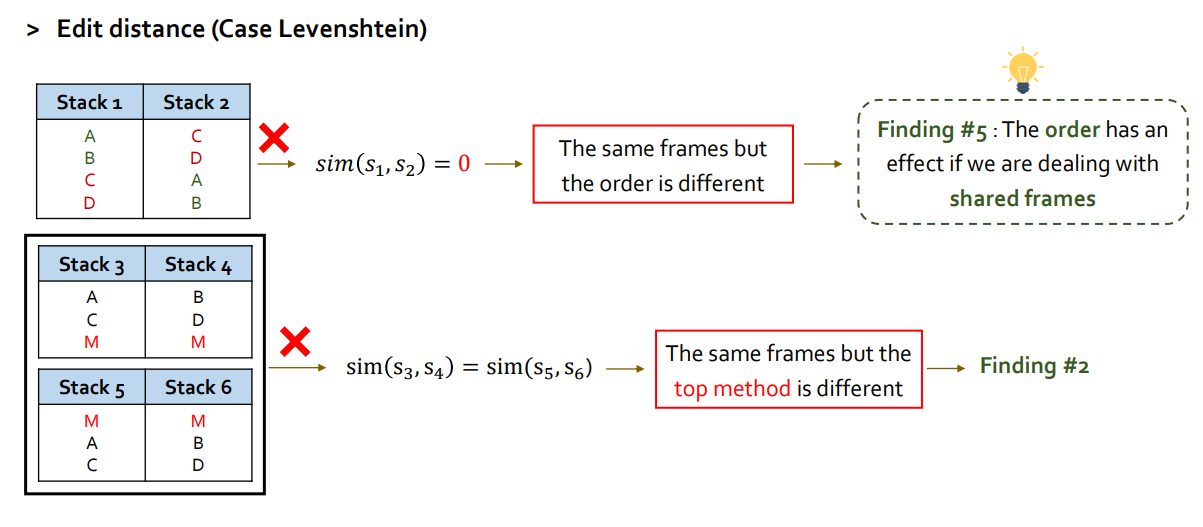

#### <font color='blue'> Complete comparison here ...  </font> 

In [108]:
data = {'Jaccard': [False, False, False, False, True],
        'Cosine Bow': [False, False, False, True, True],
        'Cosine N-grams': ['Partially', False, False, True, True],
        'Cosine TF-IDF': [False, True, False, True, True],
        'Cosine N-gram with TF-IDF': ['Partially', True, False, True, True],
        'Edit Distance': [True, False, False, True, False],
        'Rebucket': [True, False, True, False, True],
        'TraceSIM': [True, True, True, True, False],
        }
df = pd.DataFrame(data, index=['Order',
                               'Relevance',
                               'Importance',
                               'Frequency',
                               'Crossing'
                               ])
df

,Jaccard,Cosine Bow,Cosine N-grams,Cosine TF-IDF,Cosine N-gram with TF-IDF,Edit Distance,Rebucket,TraceSIM
Order,False,False,Partially,False,Partially,True,True,True
Relevance,False,False,False,True,True,False,False,True
Importance,False,False,False,False,False,False,True,True
Frequency,False,True,True,True,True,True,False,True
Crossing,True,True,True,True,True,False,True,False


#### **Based on these experiments, fill the following table**

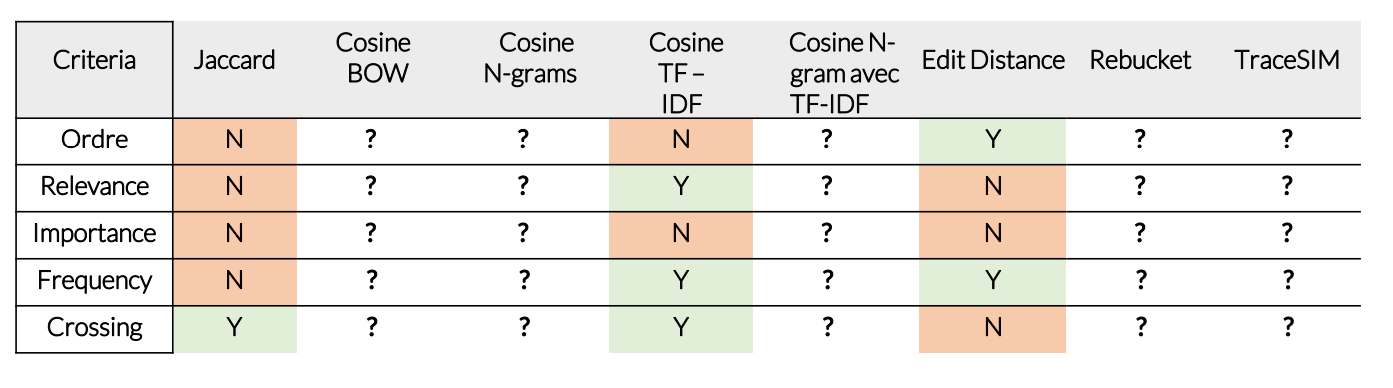